## Set up

In [2]:
import pandas as pd
from pandas import DataFrame, merge

import string
import numpy as np
import collections
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from itertools import compress

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,classification_report, \
roc_curve,auc,precision_recall_curve,roc_auc_score,average_precision_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
import statsmodels.stats.outliers_influence as oi

import seaborn as sns

from scipy import stats

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## input data

In [4]:
data = pd.read_csv('price_data.csv')

print 'num of obs: ', data.shape[0]
print 'num of variables: ', data.shape[1]
data.head()

num of obs:  99
num of variables:  19


Year  Quarter  Price      Supply     Libor         USD   IP_World  \
0  1991        1    NaN   97.826667  8.520833  100.000000        NaN   
1  1991        2    NaN  100.433333  8.583333   99.088341        NaN   
2  1991        3    NaN  103.493333  8.125000   92.842587        NaN   
3  1991        4    NaN  106.660000  7.980833   89.138751        NaN   
4  1992        1    NaN  108.280000  6.857500   92.266991  66.291278   

   IP_AdvEcon      IP_US  IP_Europe   IP_Japan  IP_EmergingEcon  IP_EMAsia  \
0         NaN        NaN        NaN        NaN              NaN        NaN   
1         NaN        NaN        NaN        NaN              NaN        NaN   
2         NaN        NaN        NaN        NaN              NaN        NaN   
3         NaN        NaN        NaN        NaN              NaN        NaN   
4   78.156641  63.355493  83.469666  98.776865         47.96406  26.730543   

   CommodityIndex  Dx_Variable  XCommodityImports  XCommodityExports1  \
0      273.376667     0.136172          10.000000           63.057981   
1      263.213333     0.108198          16.326531           74.657937   
2      286.256667     0.000000          13.346939           79.267194   
3      283.580000     0.000000          18.857143           70.979799   
4      254.490000     0.160803           8.530612           77.496501   

   XCommodityExports2  XCntry_IndustrialOutput  
0           75.760640                      NaN  
1           77.688279                      NaN  
2           94.542090                      NaN  
3           94.899992                 5.520000  
4           76.015170                 5.493333

In [5]:
col_list = data.columns.tolist()
date_col = ['Year','Quarter']

target_name = 'Price'
predictors = [i for i in col_list if i not in date_col and i <> target_name]

# create period column
data['period'] = data[['Year','Quarter']].apply(lambda x : '{}/{}/1'.format(x[0],x[1]), axis=1)
data['period'] = pd.to_datetime(data.period, format='%Y/%m/%d')

* exam data

In [6]:
#check missing values
print 'check num of missing values per column'
print ' '
for c in col_list:
    num_miss = data[c].isnull().values.ravel().sum()
    print c,': ',str(data[c].isnull().values.ravel().sum())
    if num_miss > 0: 
        print '     * missing dates: ', data.loc[data[c].isnull(),'period']
        print ' '

check num of missing values per column
 
Year :  0
Quarter :  0
Price :  7
     * missing dates:  0   1991-01-01
1   1991-02-01
2   1991-03-01
3   1991-04-01
4   1992-01-01
5   1992-02-01
6   1992-03-01
Name: period, dtype: datetime64[ns]
 
Supply :  0
Libor :  0
USD :  0
IP_World :  4
     * missing dates:  0   1991-01-01
1   1991-02-01
2   1991-03-01
3   1991-04-01
Name: period, dtype: datetime64[ns]
 
IP_AdvEcon :  4
     * missing dates:  0   1991-01-01
1   1991-02-01
2   1991-03-01
3   1991-04-01
Name: period, dtype: datetime64[ns]
 
IP_US :  4
     * missing dates:  0   1991-01-01
1   1991-02-01
2   1991-03-01
3   1991-04-01
Name: period, dtype: datetime64[ns]
 
IP_Europe :  4
     * missing dates:  0   1991-01-01
1   1991-02-01
2   1991-03-01
3   1991-04-01
Name: period, dtype: datetime64[ns]
 
IP_Japan :  4
     * missing dates:  0   1991-01-01
1   1991-02-01
2   1991-03-01
3   1991-04-01
Name: period, dtype: datetime64[ns]
 
IP_EmergingEcon :  4
     * missing dates:  0   1991

In [7]:
# drop rows with missing values
data = data.dropna()
print 'after dropping obs with missing values: '
print 'num of obs: ', data.shape[0]
print 'num of variables: ', data.shape[1]


after dropping obs with missing values: 
num of obs:  92
num of variables:  20


* visualize data: price vs other variables

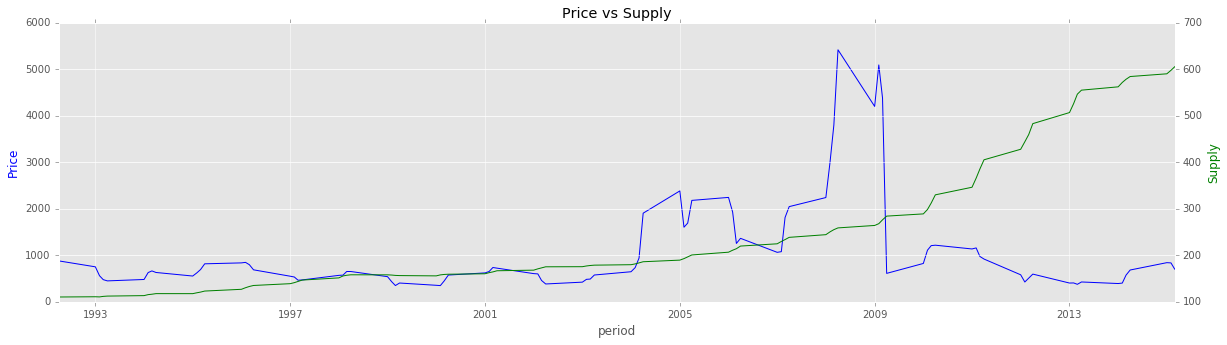

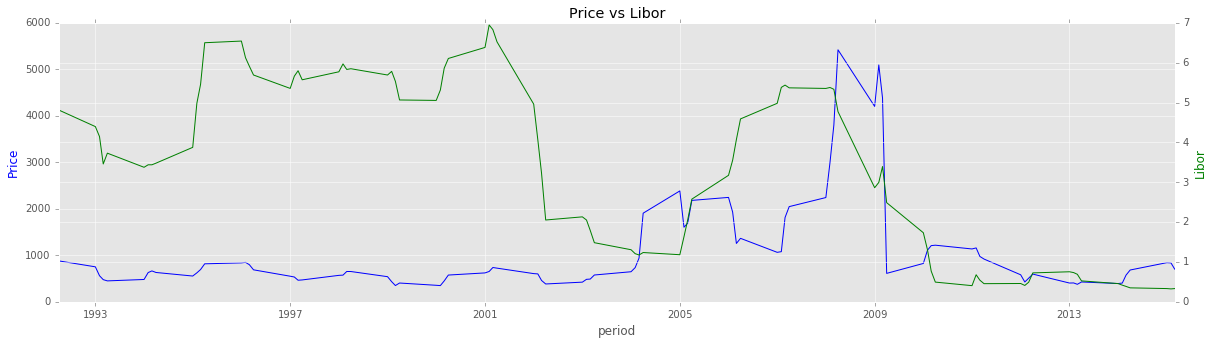

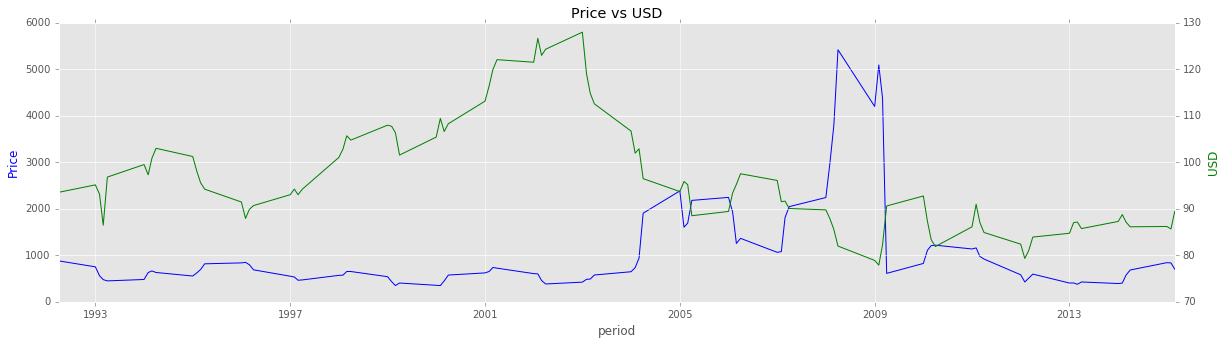

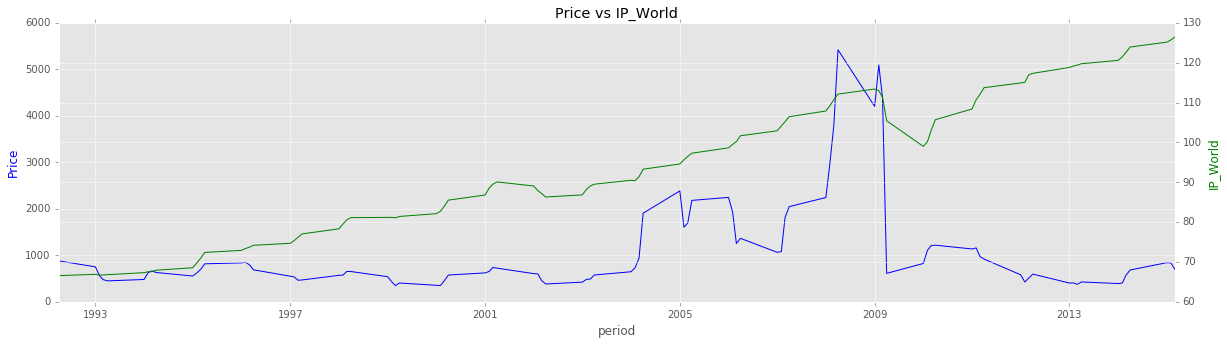

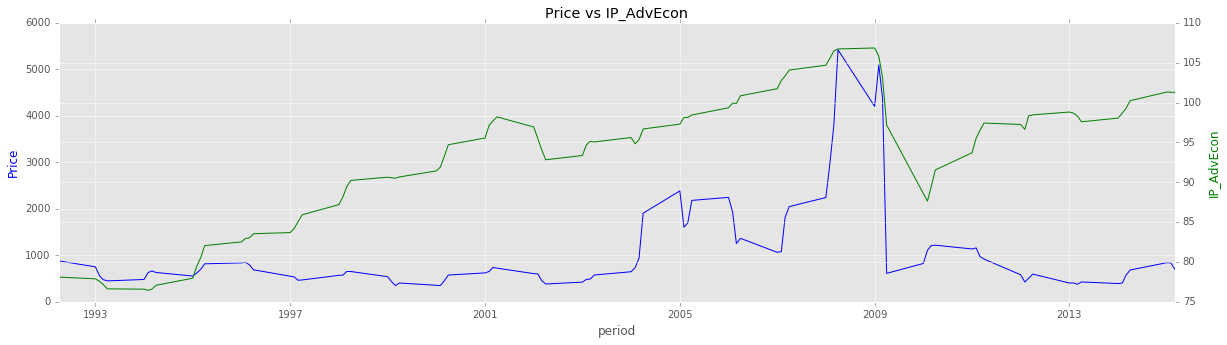

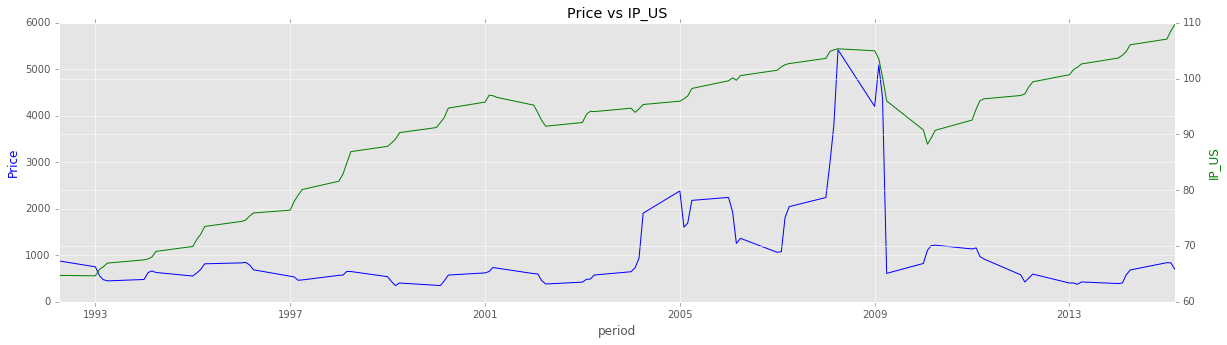

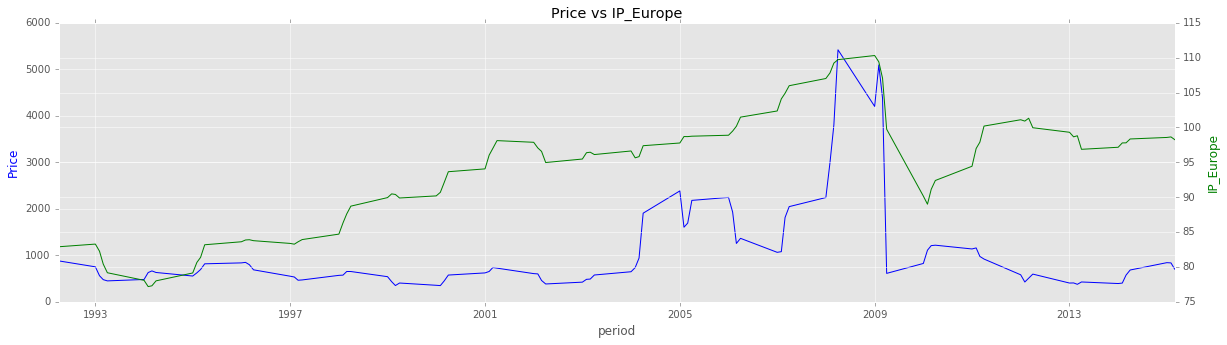

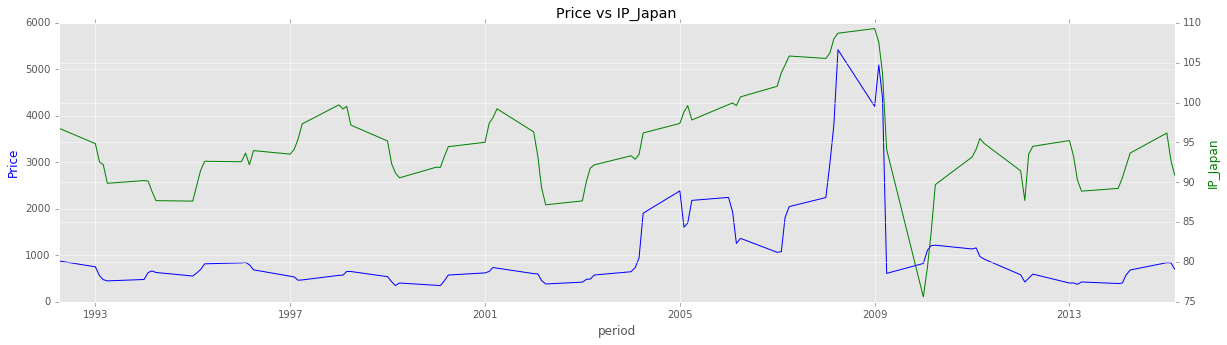

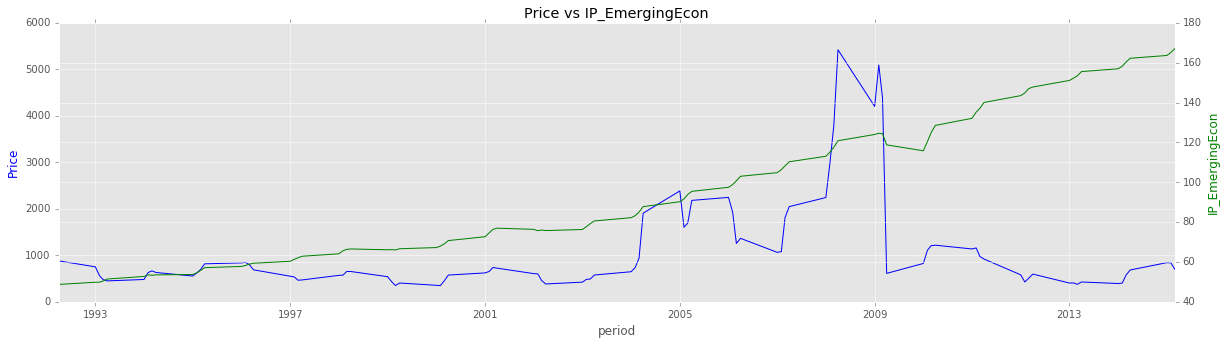

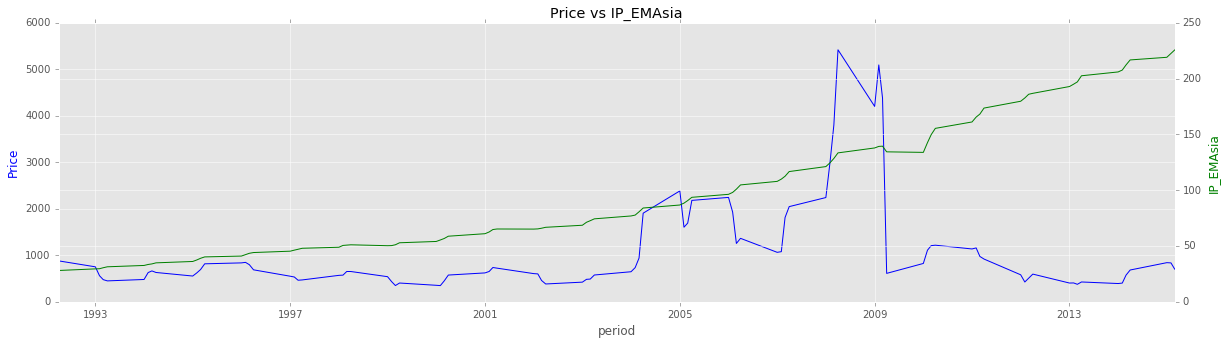

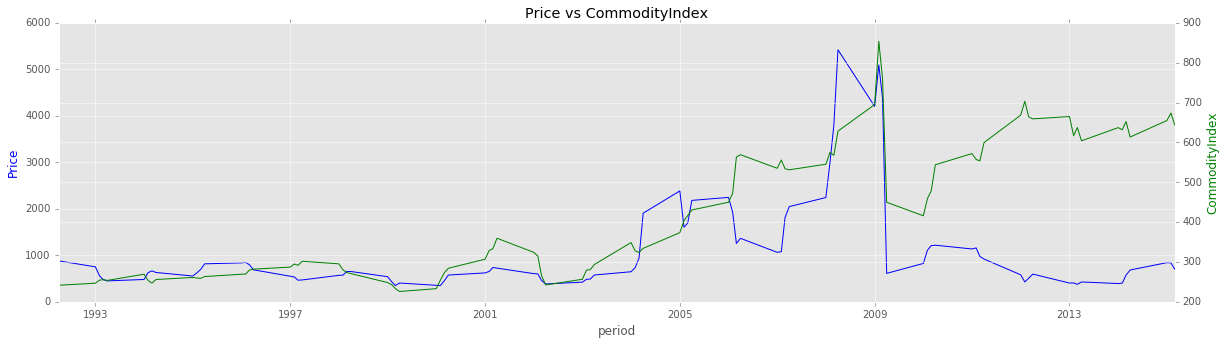

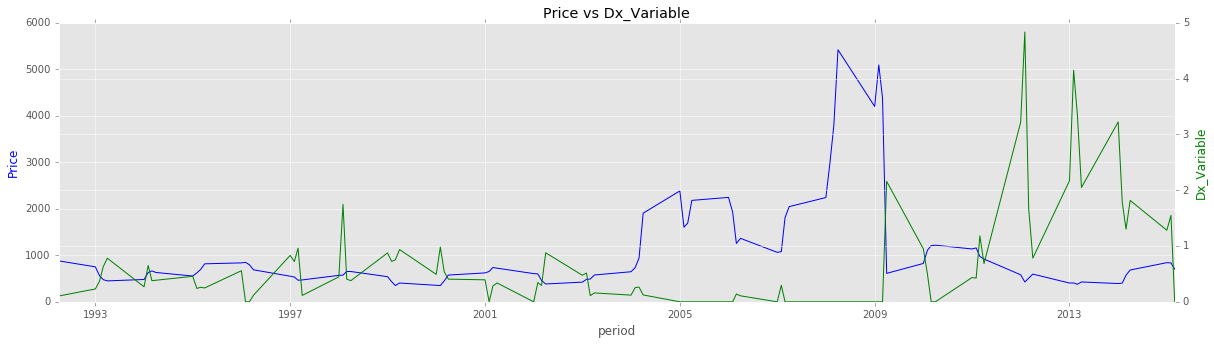

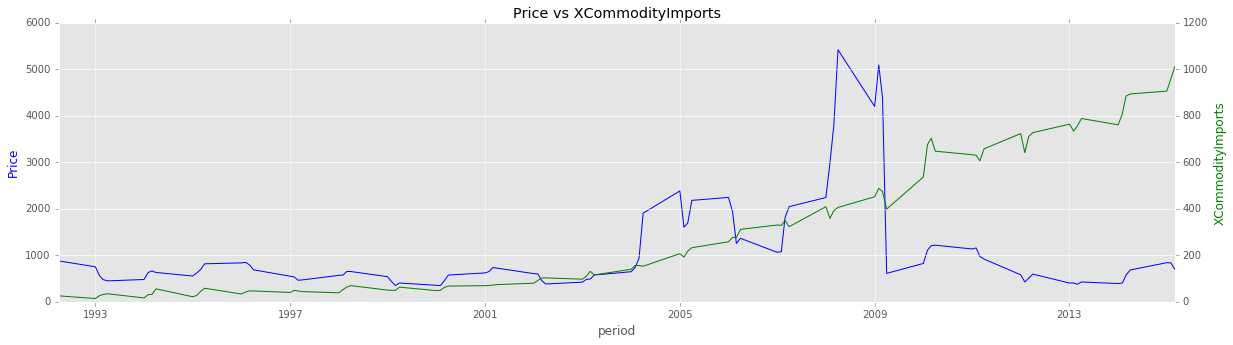

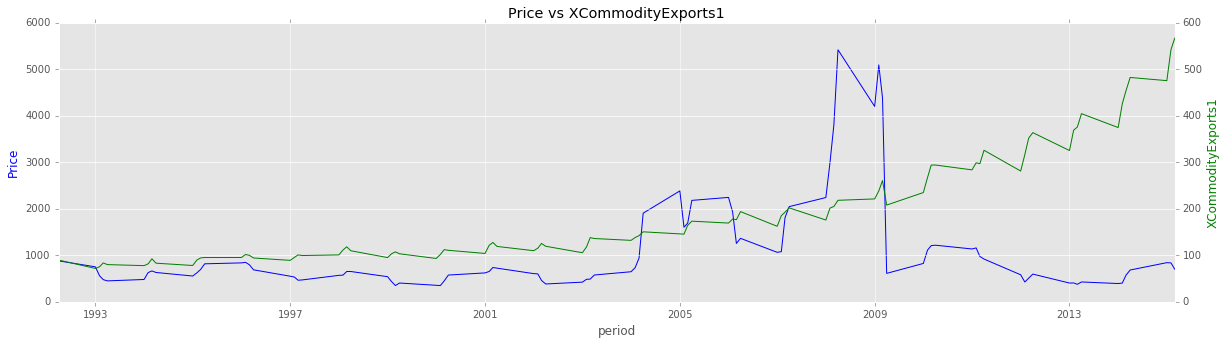

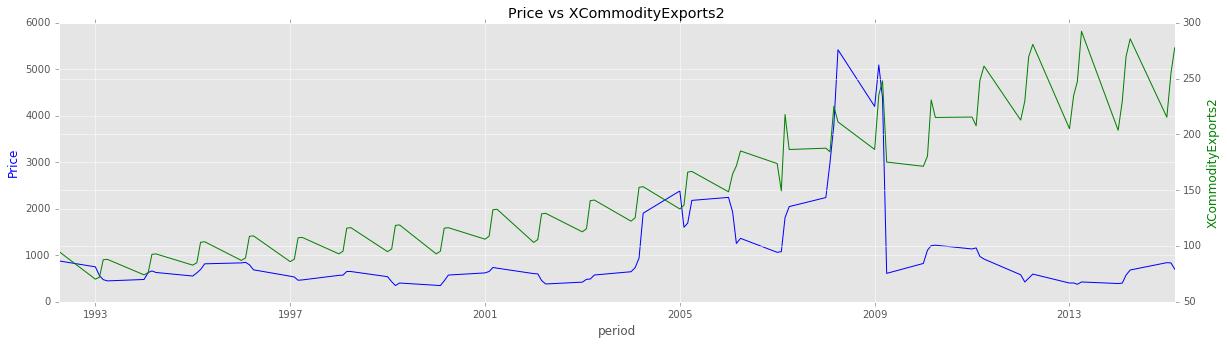

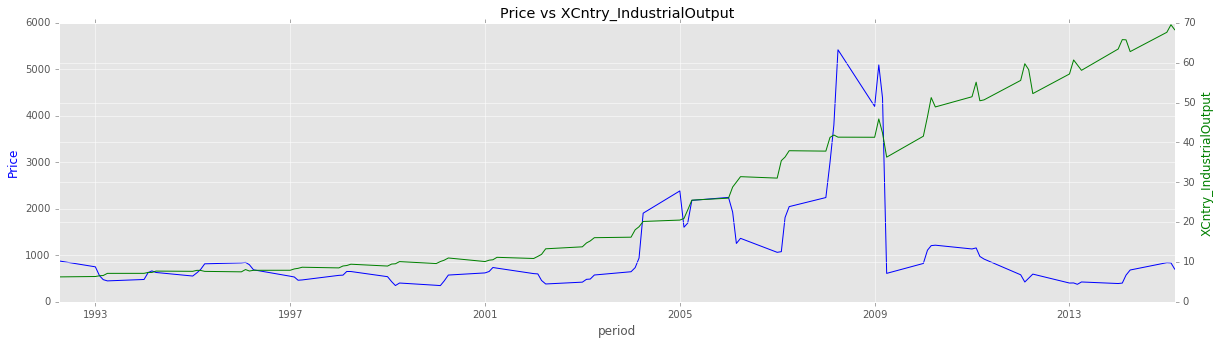

In [8]:
for v in predictors:
    
    fig, ax1 = plt.subplots(figsize=(20,5))

    ax2 = ax1.twinx() 
    ax1.plot(data.period, data[target_name], 'b-') 
    ax2.plot(data.period, data[v], 'g-') 
    
    ax1.set_xlabel('period') 
    ax1.set_ylabel(target_name, color='b') 
    ax2.set_ylabel(v, color='g')
    
    plt.title(target_name + ' vs ' + v)
    plt.show()

## check/test for stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,series_name):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=4).mean()
    rolstd = timeseries.rolling(window=4).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation - ' + series_name)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test - ' + series_name
    tr = timeseries.iloc[:,0].values
    
    dftest = adfuller(tr, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    return dfoutput['p-value']

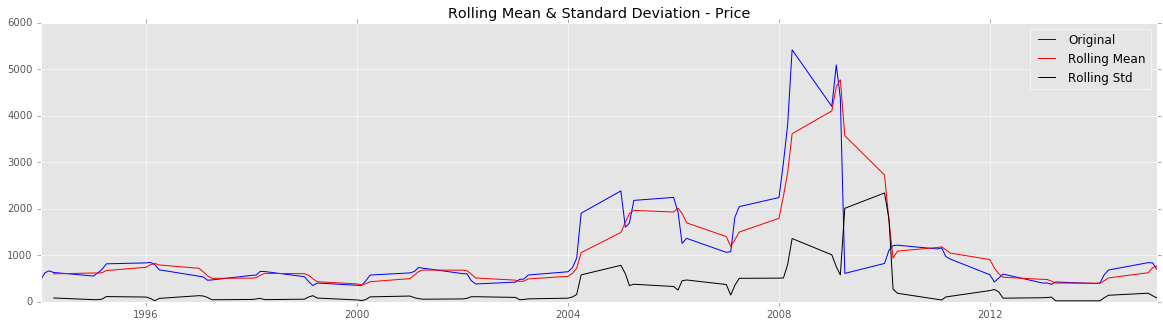

Results of Dickey-Fuller Test - Price
Test Statistic                 -3.038398
p-value                         0.031461
#Lags Used                      3.000000
Number of Observations Used    83.000000
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
Critical Value (10%)           -2.585713
dtype: float64


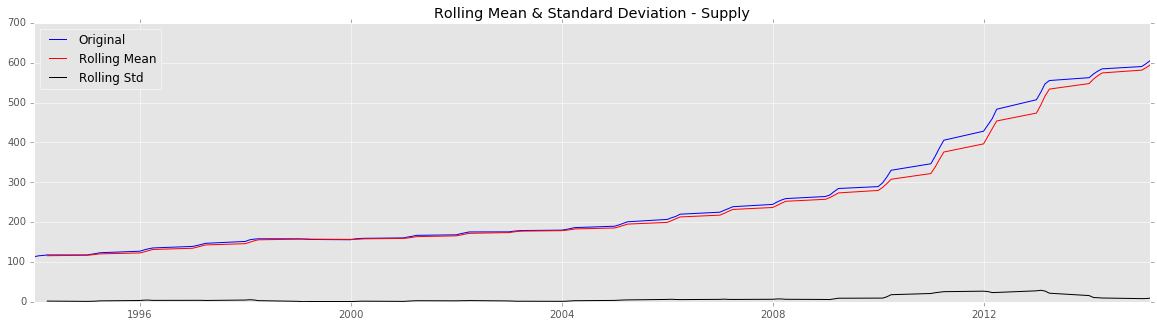

Results of Dickey-Fuller Test - Supply
Test Statistic                  3.502729
p-value                         1.000000
#Lags Used                     12.000000
Number of Observations Used    74.000000
Critical Value (5%)            -2.901470
Critical Value (1%)            -3.521980
Critical Value (10%)           -2.588072
dtype: float64


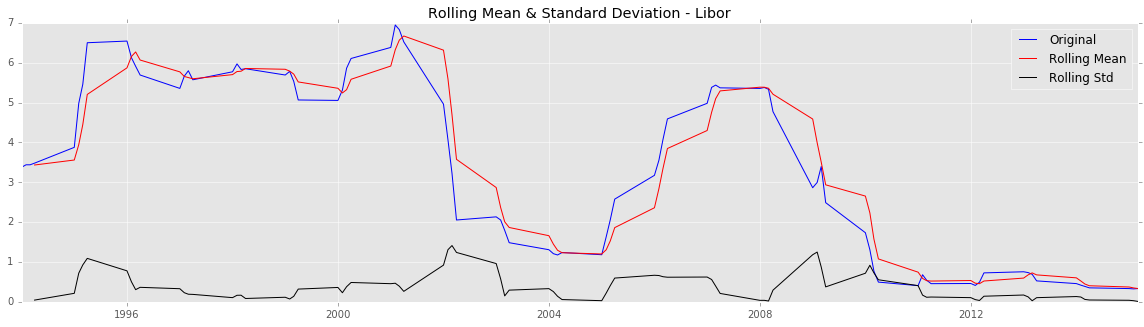

Results of Dickey-Fuller Test - Libor
Test Statistic                 -1.914491
p-value                         0.325275
#Lags Used                      3.000000
Number of Observations Used    83.000000
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
Critical Value (10%)           -2.585713
dtype: float64


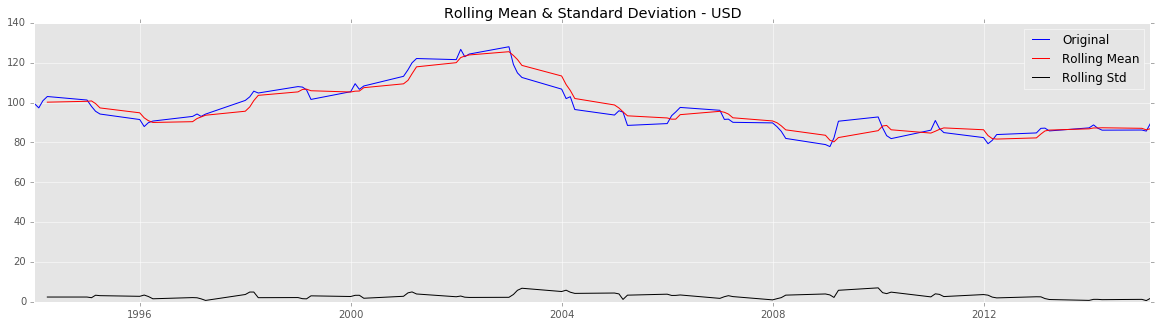

Results of Dickey-Fuller Test - USD
Test Statistic                 -1.924634
p-value                         0.320563
#Lags Used                      6.000000
Number of Observations Used    80.000000
Critical Value (5%)            -2.898409
Critical Value (1%)            -3.514869
Critical Value (10%)           -2.586439
dtype: float64


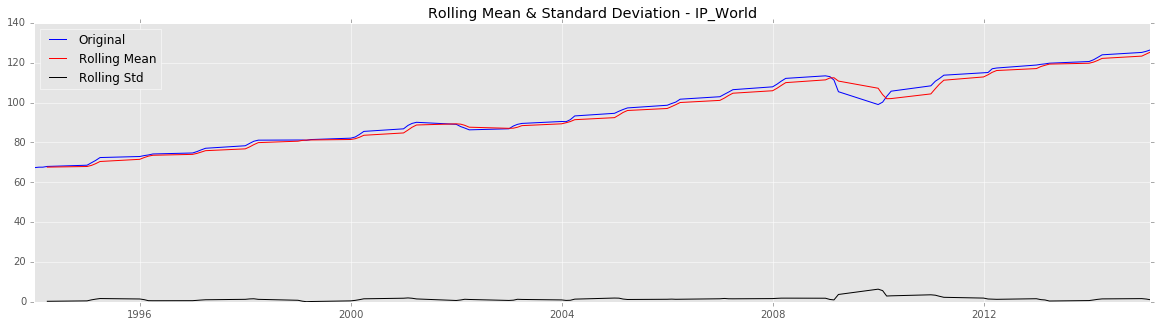

Results of Dickey-Fuller Test - IP_World
Test Statistic                 -0.358974
p-value                         0.916727
#Lags Used                      2.000000
Number of Observations Used    84.000000
Critical Value (5%)            -2.896616
Critical Value (1%)            -3.510712
Critical Value (10%)           -2.585482
dtype: float64


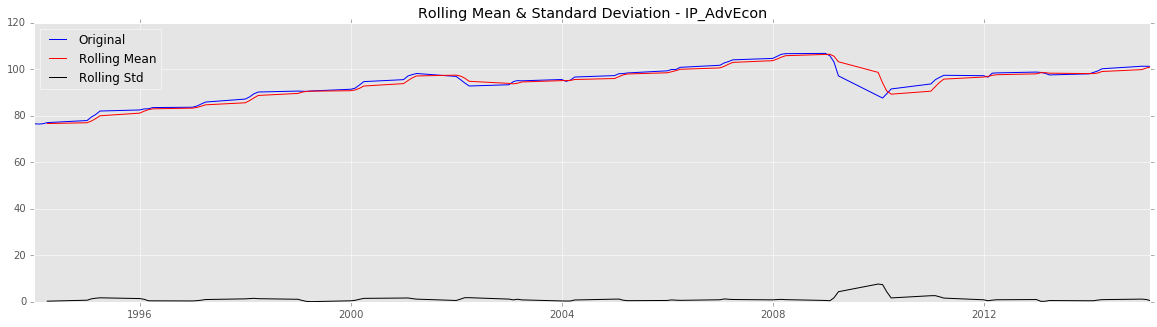

Results of Dickey-Fuller Test - IP_AdvEcon
Test Statistic                 -2.422597
p-value                         0.135460
#Lags Used                      2.000000
Number of Observations Used    84.000000
Critical Value (5%)            -2.896616
Critical Value (1%)            -3.510712
Critical Value (10%)           -2.585482
dtype: float64


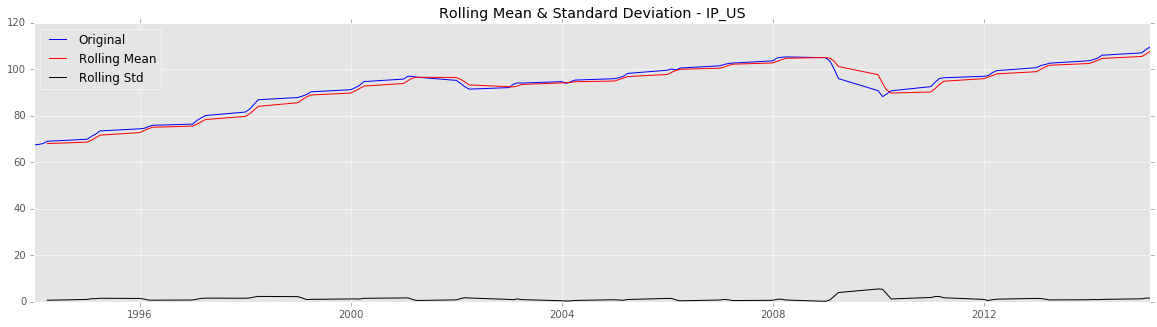

Results of Dickey-Fuller Test - IP_US
Test Statistic                 -1.907232
p-value                         0.328667
#Lags Used                      2.000000
Number of Observations Used    84.000000
Critical Value (5%)            -2.896616
Critical Value (1%)            -3.510712
Critical Value (10%)           -2.585482
dtype: float64


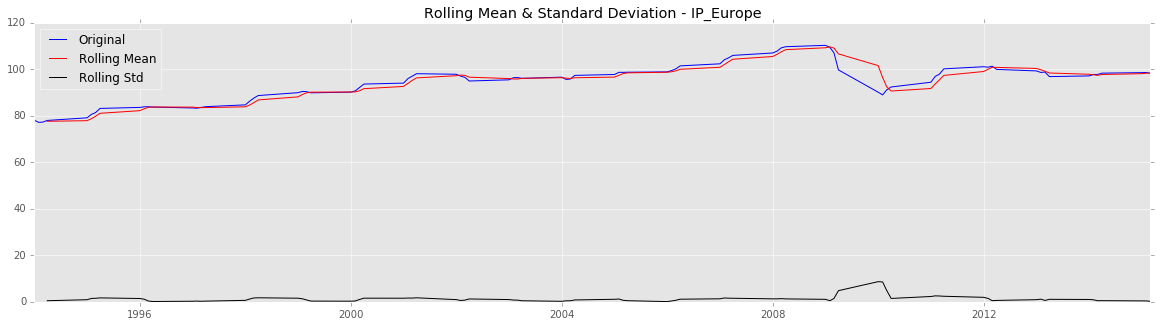

Results of Dickey-Fuller Test - IP_Europe
Test Statistic                 -2.399255
p-value                         0.141947
#Lags Used                      2.000000
Number of Observations Used    84.000000
Critical Value (5%)            -2.896616
Critical Value (1%)            -3.510712
Critical Value (10%)           -2.585482
dtype: float64


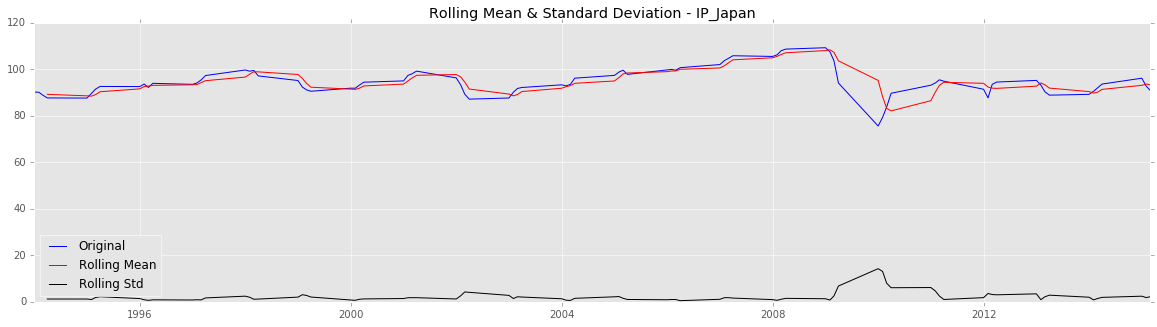

Results of Dickey-Fuller Test - IP_Japan
Test Statistic                 -3.818327
p-value                         0.002725
#Lags Used                      1.000000
Number of Observations Used    85.000000
Critical Value (5%)            -2.896195
Critical Value (1%)            -3.509736
Critical Value (10%)           -2.585258
dtype: float64


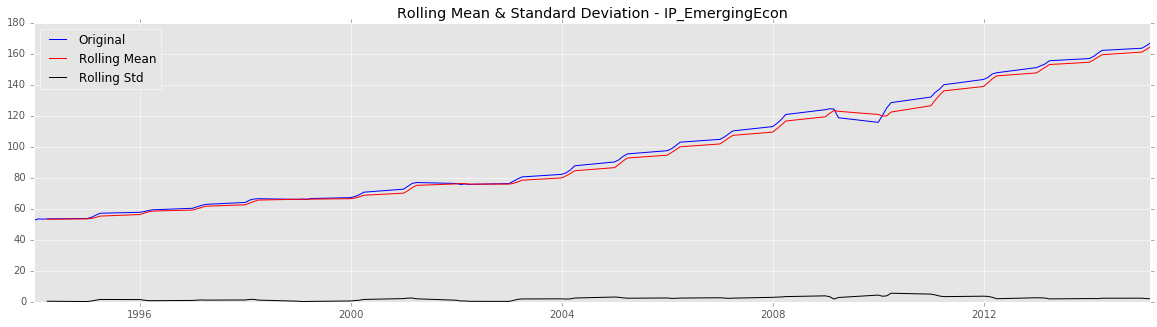

Results of Dickey-Fuller Test - IP_EmergingEcon
Test Statistic                  1.884215
p-value                         0.998502
#Lags Used                      2.000000
Number of Observations Used    84.000000
Critical Value (5%)            -2.896616
Critical Value (1%)            -3.510712
Critical Value (10%)           -2.585482
dtype: float64


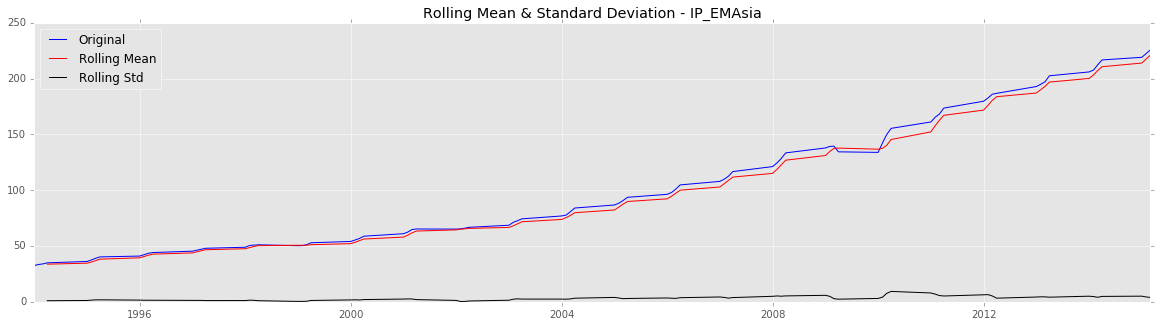

Results of Dickey-Fuller Test - IP_EMAsia
Test Statistic                  3.397636
p-value                         1.000000
#Lags Used                      2.000000
Number of Observations Used    84.000000
Critical Value (5%)            -2.896616
Critical Value (1%)            -3.510712
Critical Value (10%)           -2.585482
dtype: float64


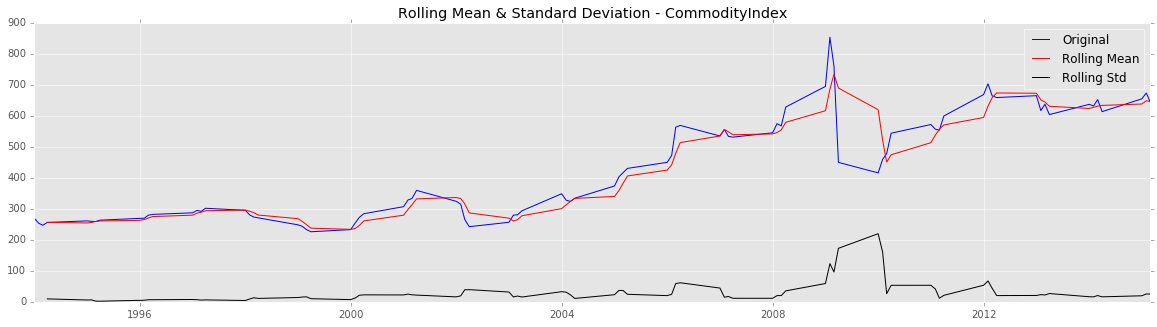

Results of Dickey-Fuller Test - CommodityIndex
Test Statistic                 -1.104215
p-value                         0.713388
#Lags Used                      2.000000
Number of Observations Used    84.000000
Critical Value (5%)            -2.896616
Critical Value (1%)            -3.510712
Critical Value (10%)           -2.585482
dtype: float64


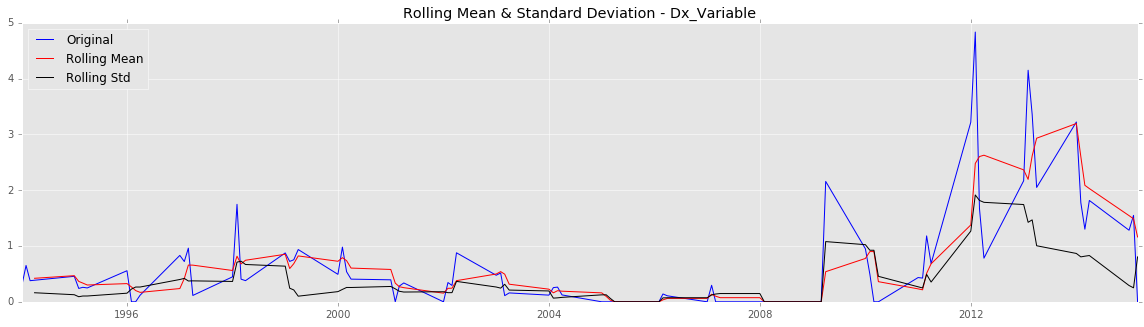

Results of Dickey-Fuller Test - Dx_Variable
Test Statistic                 -2.506119
p-value                         0.113992
#Lags Used                     10.000000
Number of Observations Used    76.000000
Critical Value (5%)            -2.900395
Critical Value (1%)            -3.519481
Critical Value (10%)           -2.587498
dtype: float64


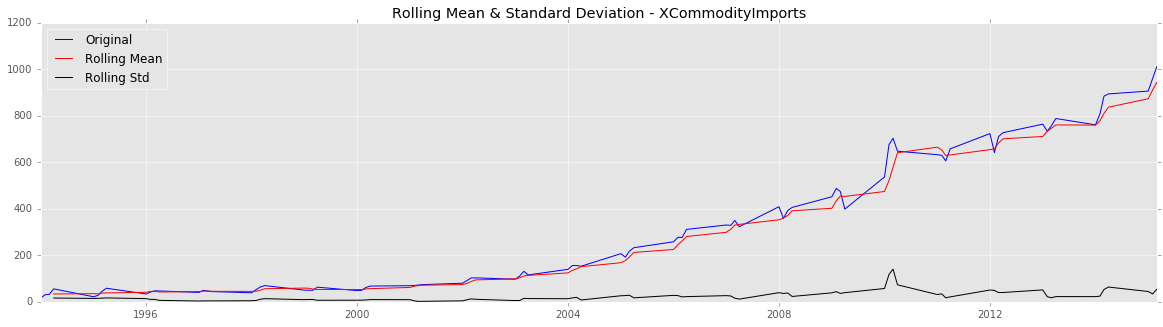

Results of Dickey-Fuller Test - XCommodityImports
Test Statistic                  3.324144
p-value                         1.000000
#Lags Used                      3.000000
Number of Observations Used    83.000000
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
Critical Value (10%)           -2.585713
dtype: float64


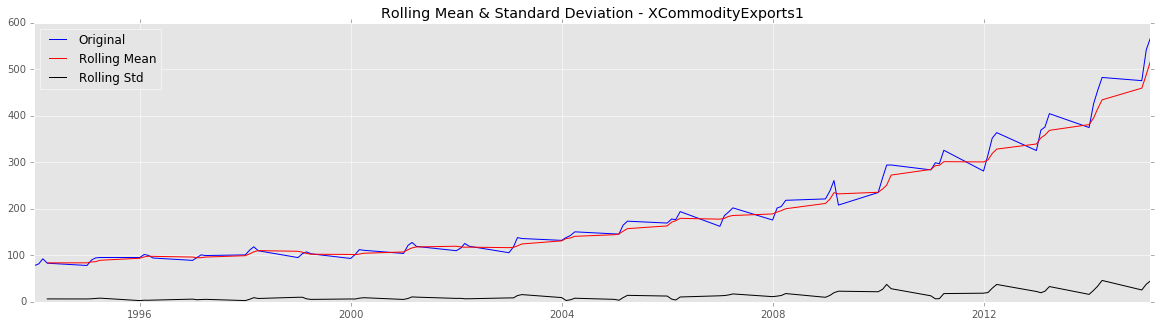

Results of Dickey-Fuller Test - XCommodityExports1
Test Statistic                  4.399248
p-value                         1.000000
#Lags Used                      4.000000
Number of Observations Used    82.000000
Critical Value (5%)            -2.897490
Critical Value (1%)            -3.512738
Critical Value (10%)           -2.585949
dtype: float64


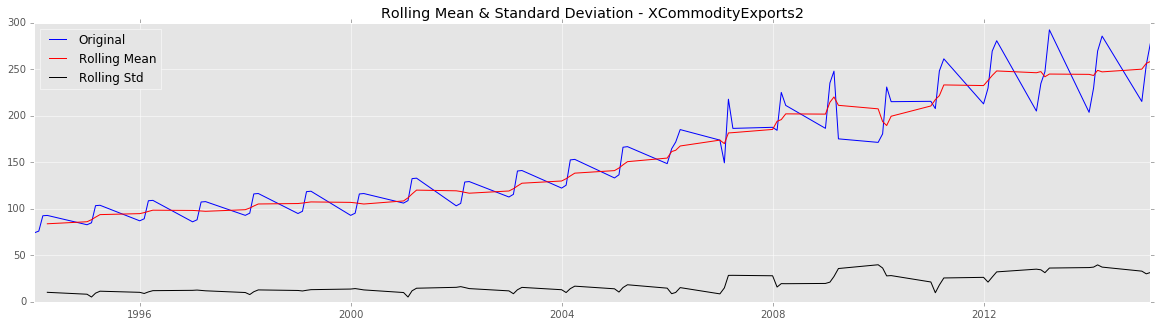

Results of Dickey-Fuller Test - XCommodityExports2
Test Statistic                  0.548044
p-value                         0.986262
#Lags Used                      3.000000
Number of Observations Used    83.000000
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
Critical Value (10%)           -2.585713
dtype: float64


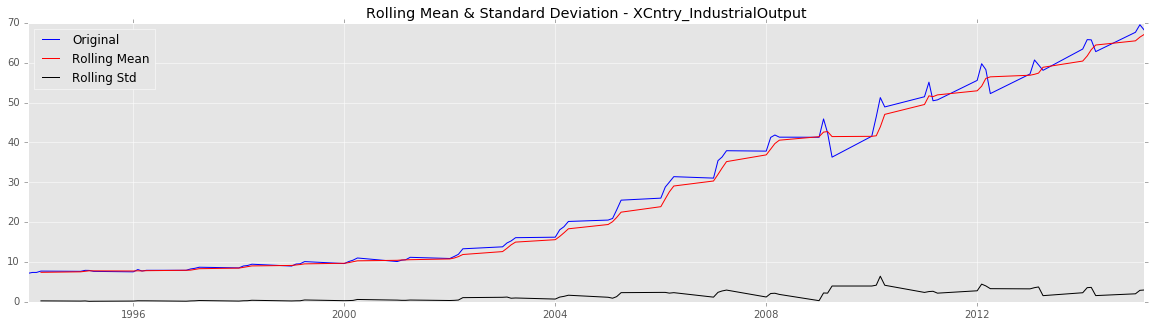

Results of Dickey-Fuller Test - XCntry_IndustrialOutput
Test Statistic                  1.116289
p-value                         0.995353
#Lags Used                      9.000000
Number of Observations Used    77.000000
Critical Value (5%)            -2.899878
Critical Value (1%)            -3.518281
Critical Value (10%)           -2.587223
dtype: float64
 
Non-stationary variables:  ['Supply', 'Libor', 'USD', 'IP_World', 'IP_AdvEcon', 'IP_US', 'IP_Europe', 'IP_EmergingEcon', 'IP_EMAsia', 'CommodityIndex', 'Dx_Variable', 'XCommodityImports', 'XCommodityExports1', 'XCommodityExports2', 'XCntry_IndustrialOutput']


In [10]:
non_stationary_var = []

for v in [target_name] + predictors:
    timeseries = data.loc[data['Year'] > 1993,[v]]
    timeseries.index = data.loc[data['Year'] > 1993,'period']
    pvalue = test_stationarity(timeseries,v)
    
    if pvalue > 0.05: non_stationary_var.append(v)

print ' '
print 'Non-stationary variables: ', 
print non_stationary_var

## stationarize time series variables

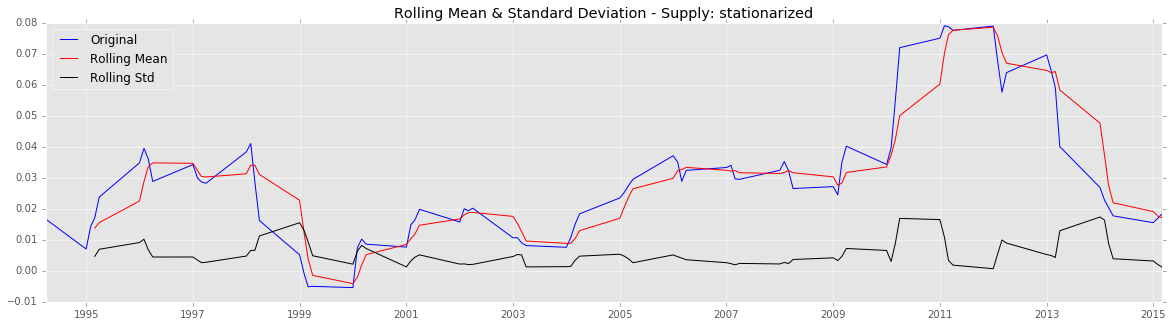

Results of Dickey-Fuller Test - Supply: stationarized
Test Statistic                 -2.393712
p-value                         0.143519
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (5%)            -2.897490
Critical Value (1%)            -3.512738
Critical Value (10%)           -2.585949
dtype: float64


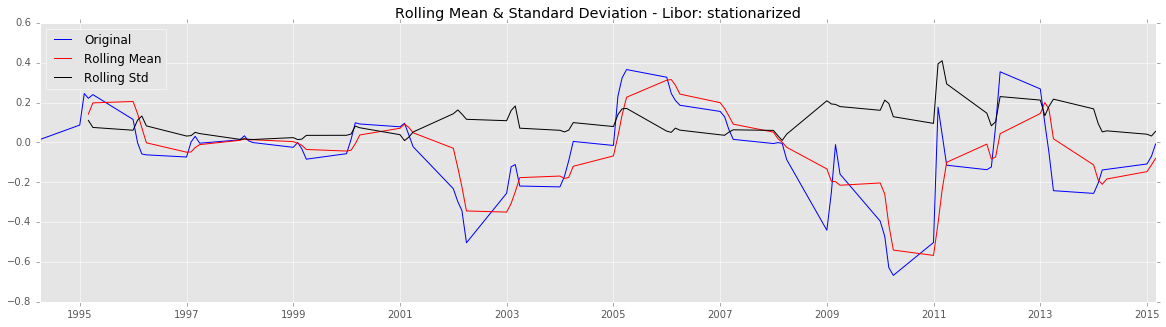

Results of Dickey-Fuller Test - Libor: stationarized
Test Statistic                 -4.012266
p-value                         0.001348
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (5%)            -2.897490
Critical Value (1%)            -3.512738
Critical Value (10%)           -2.585949
dtype: float64


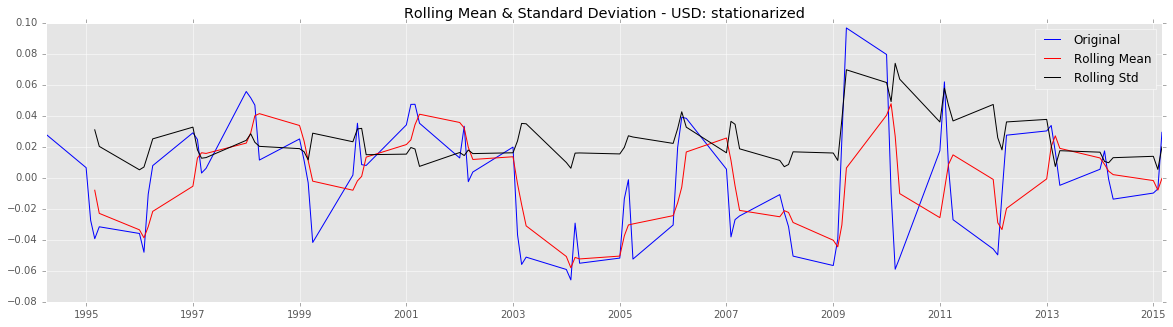

Results of Dickey-Fuller Test - USD: stationarized
Test Statistic                 -3.441507
p-value                         0.009623
#Lags Used                      8.000000
Number of Observations Used    75.000000
Critical Value (5%)            -2.900925
Critical Value (1%)            -3.520713
Critical Value (10%)           -2.587781
dtype: float64


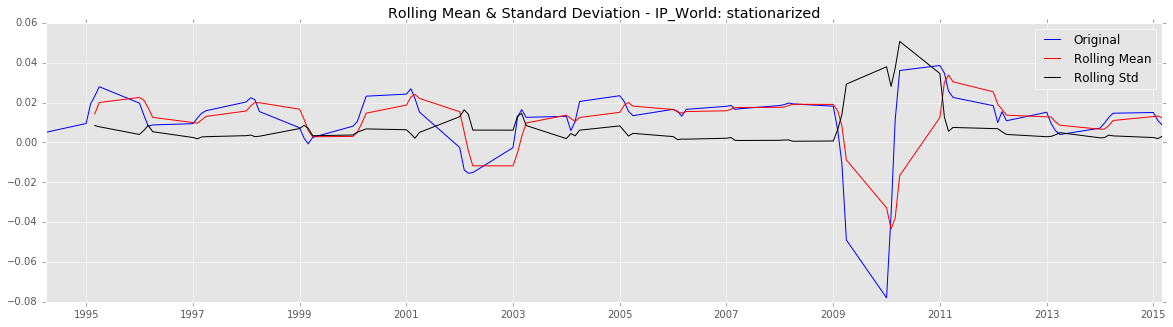

Results of Dickey-Fuller Test - IP_World: stationarized
Test Statistic                -7.046538e+00
p-value                        5.667669e-10
#Lags Used                     1.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (5%)           -2.897490e+00
Critical Value (1%)           -3.512738e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


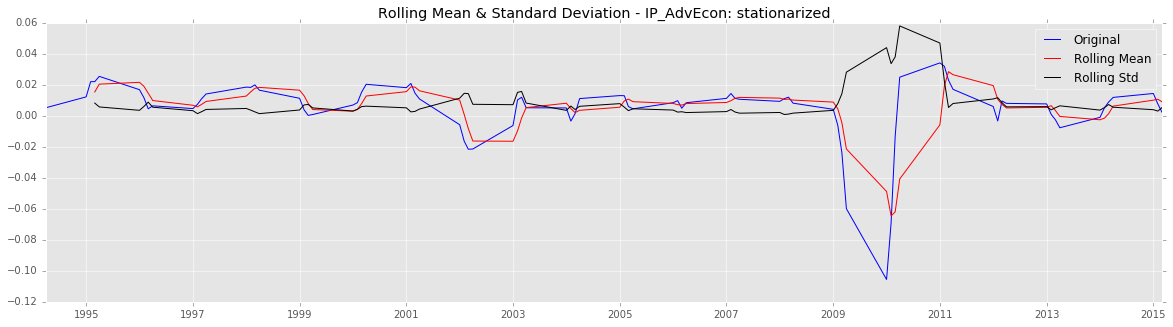

Results of Dickey-Fuller Test - IP_AdvEcon: stationarized
Test Statistic                -6.347427e+00
p-value                        2.661639e-08
#Lags Used                     1.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (5%)           -2.897490e+00
Critical Value (1%)           -3.512738e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


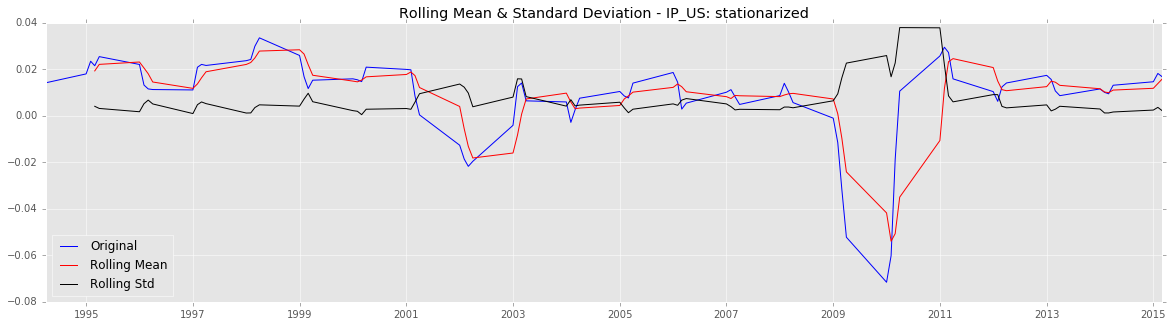

Results of Dickey-Fuller Test - IP_US: stationarized
Test Statistic                 -3.723200
p-value                         0.003798
#Lags Used                      2.000000
Number of Observations Used    81.000000
Critical Value (5%)            -2.897943
Critical Value (1%)            -3.513790
Critical Value (10%)           -2.586191
dtype: float64


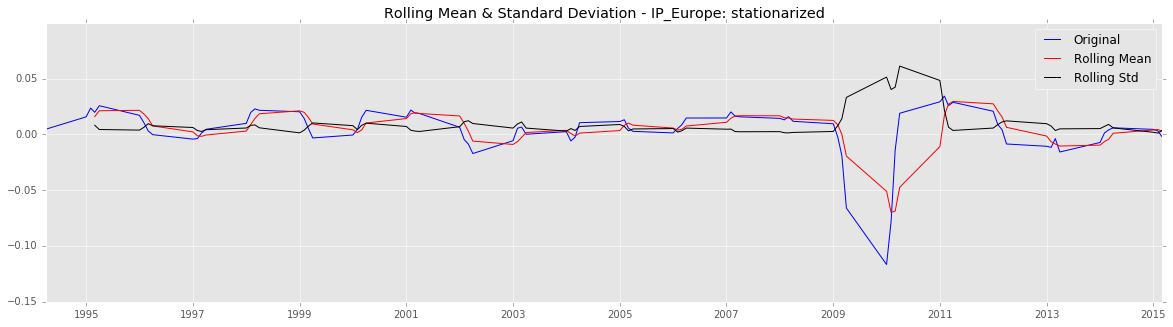

Results of Dickey-Fuller Test - IP_Europe: stationarized
Test Statistic                -5.934678e+00
p-value                        2.336085e-07
#Lags Used                     1.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (5%)           -2.897490e+00
Critical Value (1%)           -3.512738e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


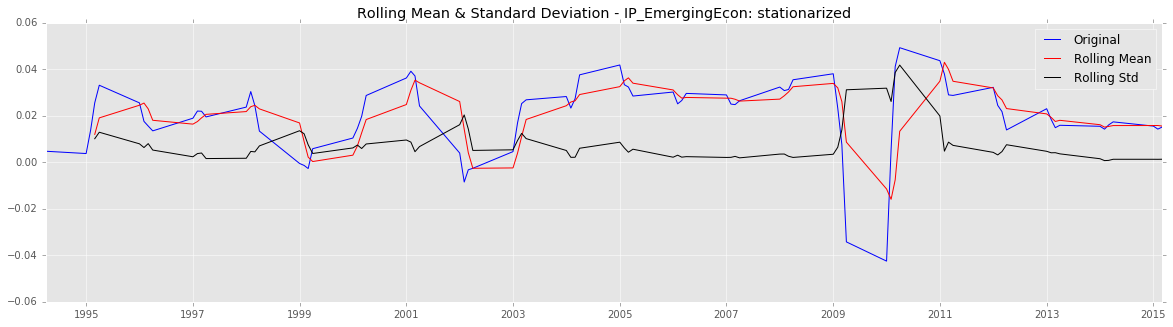

Results of Dickey-Fuller Test - IP_EmergingEcon: stationarized
Test Statistic                -6.867454e+00
p-value                        1.546024e-09
#Lags Used                     1.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (5%)           -2.897490e+00
Critical Value (1%)           -3.512738e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


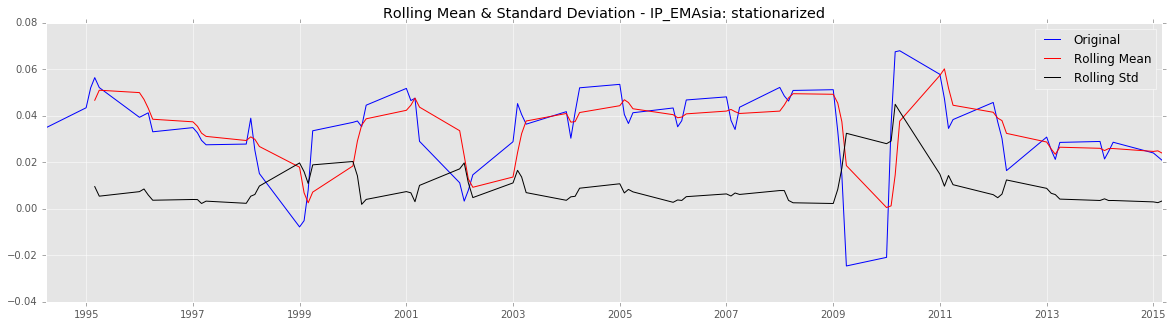

Results of Dickey-Fuller Test - IP_EMAsia: stationarized
Test Statistic                -6.090430e+00
p-value                        1.039662e-07
#Lags Used                     1.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (5%)           -2.897490e+00
Critical Value (1%)           -3.512738e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


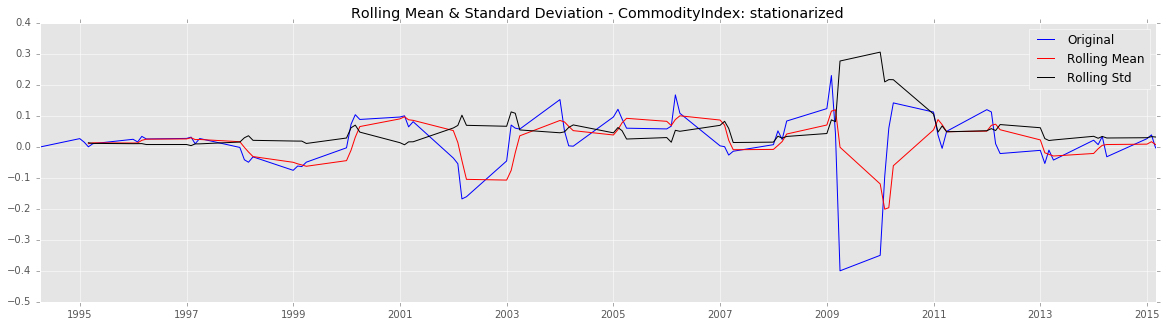

Results of Dickey-Fuller Test - CommodityIndex: stationarized
Test Statistic                -6.964539e+00
p-value                        8.985268e-10
#Lags Used                     1.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (5%)           -2.897490e+00
Critical Value (1%)           -3.512738e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


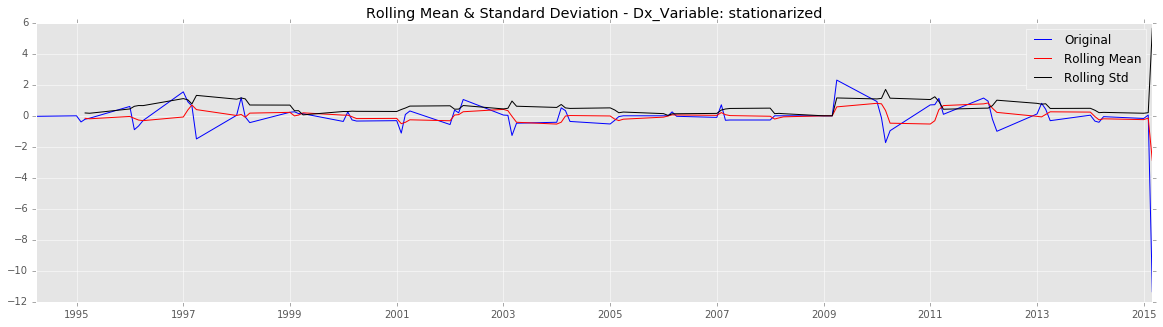

Results of Dickey-Fuller Test - Dx_Variable: stationarized
Test Statistic                 -3.179404
p-value                         0.021208
#Lags Used                      0.000000
Number of Observations Used    83.000000
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
Critical Value (10%)           -2.585713
dtype: float64


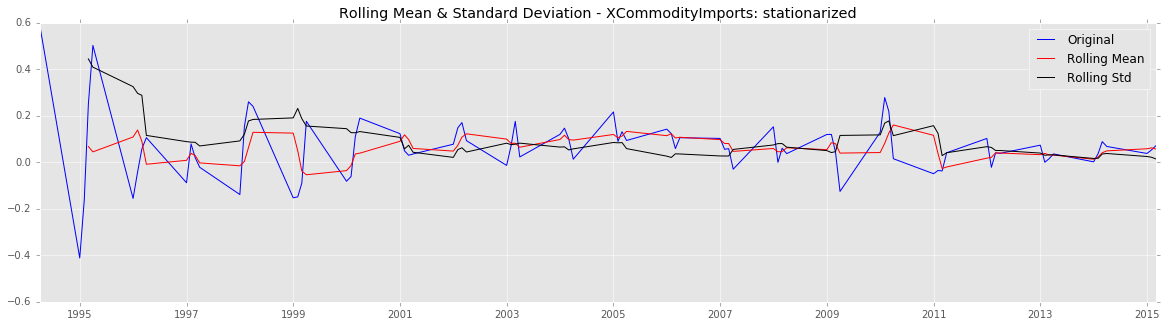

Results of Dickey-Fuller Test - XCommodityImports: stationarized
Test Statistic                 -5.040554
p-value                         0.000018
#Lags Used                      4.000000
Number of Observations Used    79.000000
Critical Value (5%)            -2.898886
Critical Value (1%)            -3.515977
Critical Value (10%)           -2.586694
dtype: float64


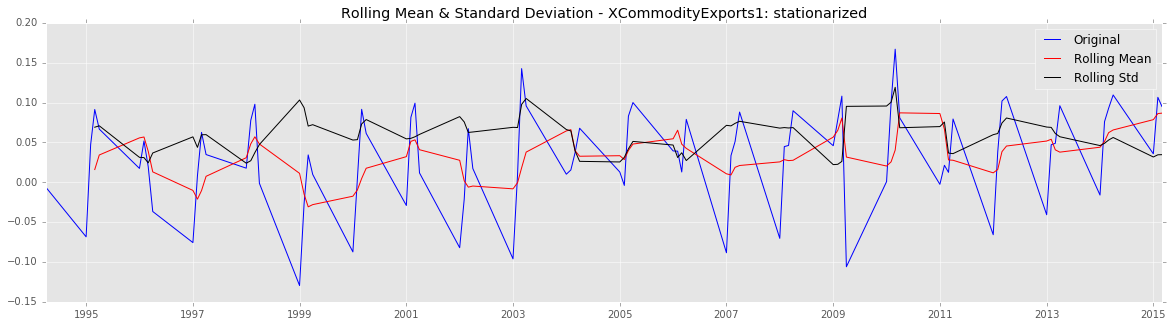

Results of Dickey-Fuller Test - XCommodityExports1: stationarized
Test Statistic                 -2.688752
p-value                         0.076005
#Lags Used                      6.000000
Number of Observations Used    77.000000
Critical Value (5%)            -2.899878
Critical Value (1%)            -3.518281
Critical Value (10%)           -2.587223
dtype: float64


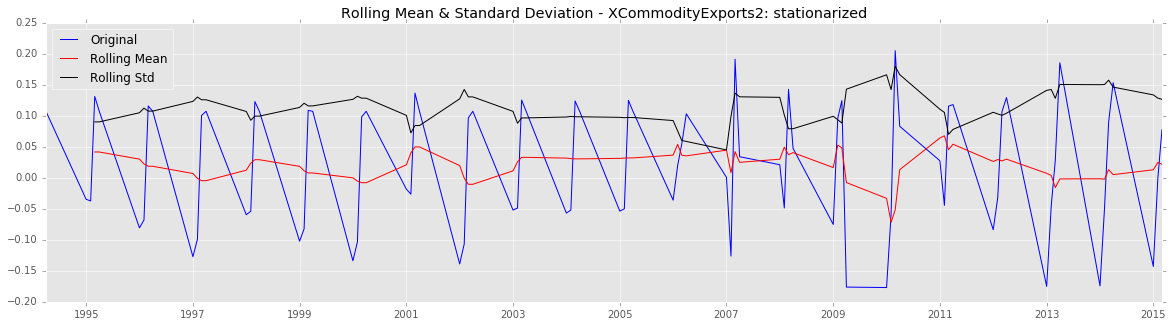

Results of Dickey-Fuller Test - XCommodityExports2: stationarized
Test Statistic                 -5.532628
p-value                         0.000002
#Lags Used                      5.000000
Number of Observations Used    78.000000
Critical Value (5%)            -2.899375
Critical Value (1%)            -3.517114
Critical Value (10%)           -2.586955
dtype: float64


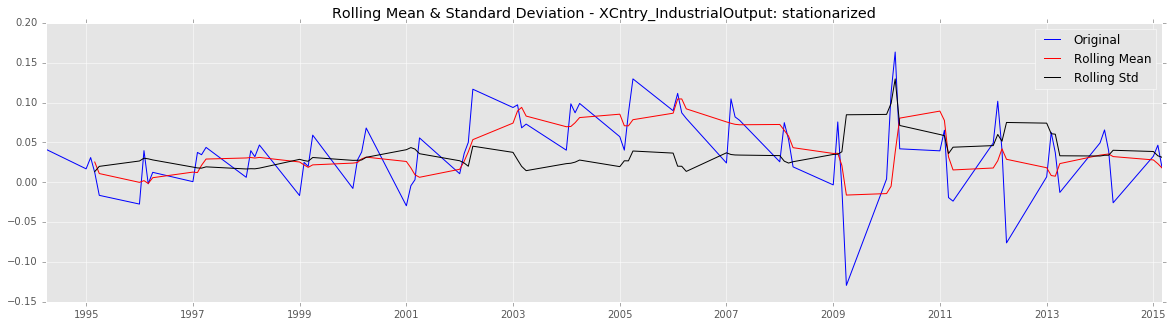

Results of Dickey-Fuller Test - XCntry_IndustrialOutput: stationarized
Test Statistic                 -1.809337
p-value                         0.375836
#Lags Used                      9.000000
Number of Observations Used    74.000000
Critical Value (5%)            -2.901470
Critical Value (1%)            -3.521980
Critical Value (10%)           -2.588072
dtype: float64
 
still Non-stationary variables:  ['Supply', 'XCommodityExports1', 'XCntry_IndustrialOutput']


In [11]:
np.seterr(divide='ignore')
updated_non_stationary_var = []

stationarized_var = dict()

for v in non_stationary_var:
    timeseries = data.loc[data['Year'] > 1993,[v]]
    timeseries.index = data.loc[data['Year'] > 1993,'period']
    
    timeseries.loc[timeseries[v] == 0,v] = 0.1  # impute for zero values

    # eliminate trend
    ts_log = np.log(timeseries)
    
    # smoothing
    
    ## 4-window rolling average: okay
    moving_avg = ts_log.rolling(window = 4).mean()
    ts_log_moving_avg_diff = ts_log - moving_avg
    ts_log_moving_avg_diff.dropna(inplace=True)
        
    ## exponational weighted moving average
    #expwighted_avg = ts_log.ewm(halflife=4).mean()
    #ts_log_ewma_diff = ts_log - expwighted_avg
    
    ## differencing: too strong
    #ts_log_diff = ts_log - ts_log.shift()
    #ts_log_diff.dropna(inplace=True)

    
    
    # re-test
    pvalue = test_stationarity(ts_log_moving_avg_diff,v + ': stationarized')
    
    if pvalue > 0.05: 
        updated_non_stationary_var.append(v)
    else:
        stationarized_var[ v + '_st'] = ts_log_moving_avg_diff
        

print ' '
print 'still Non-stationary variables: ', 
print updated_non_stationary_var


* further decompose still-non-stationary variables

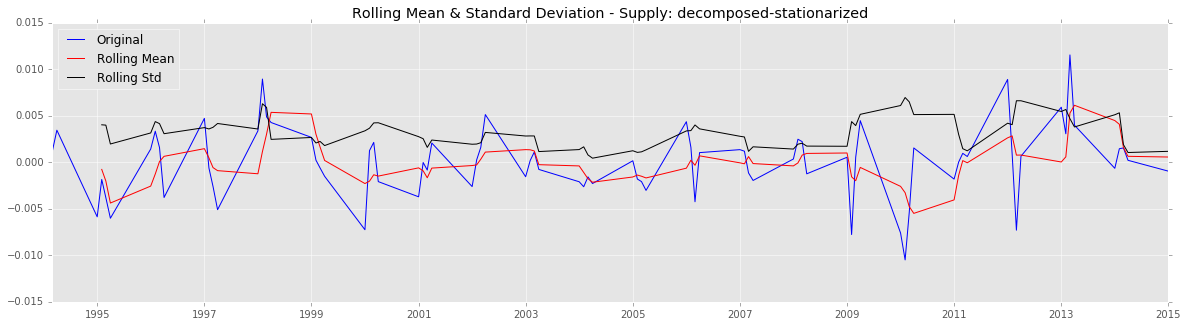

Results of Dickey-Fuller Test - Supply: decomposed-stationarized
Test Statistic                -6.494992e+00
p-value                        1.200467e-08
#Lags Used                     1.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (5%)           -2.897943e+00
Critical Value (1%)           -3.513790e+00
Critical Value (10%)          -2.586191e+00
dtype: float64


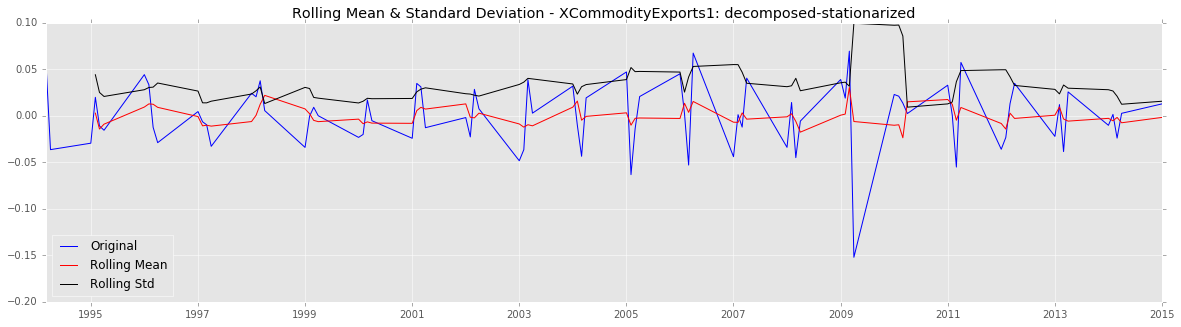

Results of Dickey-Fuller Test - XCommodityExports1: decomposed-stationarized
Test Statistic                 -5.273367
p-value                         0.000006
#Lags Used                     11.000000
Number of Observations Used    71.000000
Critical Value (5%)            -2.903200
Critical Value (1%)            -3.526005
Critical Value (10%)           -2.588995
dtype: float64


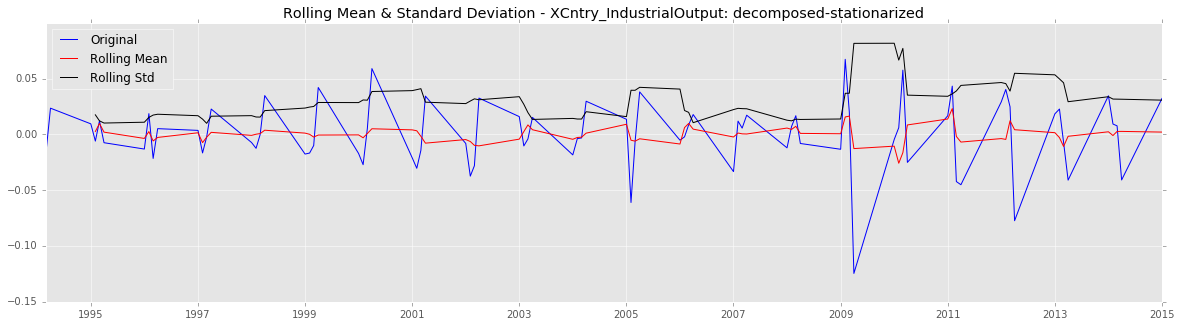

Results of Dickey-Fuller Test - XCntry_IndustrialOutput: decomposed-stationarized
Test Statistic                 -4.122811
p-value                         0.000888
#Lags Used                      8.000000
Number of Observations Used    74.000000
Critical Value (5%)            -2.901470
Critical Value (1%)            -3.521980
Critical Value (10%)           -2.588072
dtype: float64
 
still non-stationary variable: 
[]


In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame, DatetimeIndex

further_updated_non_stationary_var = []

for v in updated_non_stationary_var:
    timeseries = data.loc[data['Year'] > 1993,[v]]
    timeseries.index = data.loc[data['Year'] > 1993,'period']
    
    timeseries.loc[timeseries[v] == 0,v] = 0.1  # impute for zero values

    # eliminate trend
    ts_log = np.log(timeseries)
    
    ts_log_ = pd.DataFrame(ts_log[v].values, DatetimeIndex(start='1994-01-01',
                                      periods=len(ts_log[v].values),
                                      freq='Q'))

    
    decomposition = seasonal_decompose(ts_log_)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
        
    ts_log_decompose = residual
    ts_log_decompose.index = ts_log.index
    
    ts_log_decompose.dropna(inplace=True)

    pvalue = test_stationarity(ts_log_decompose,v + ': decomposed-stationarized')

    if pvalue > 0.5: 
        further_updated_non_stationary_var.append(v)
    else:
        stationarized_var[ v + '_st'] = ts_log_decompose


print ' '
print 'still non-stationary variable: '
print further_updated_non_stationary_var

* final review time-series after checking and making stationarity

In [13]:
# add stationalized vars back to data
data.index = data['period']
for k,v in stationarized_var.items():
    v.columns = [k]
    data = data.join(v)
    
data.dropna(inplace = True)

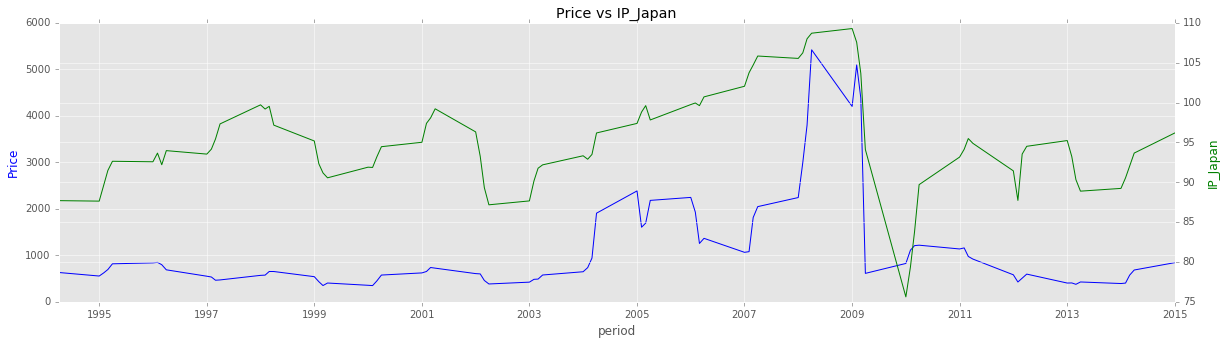

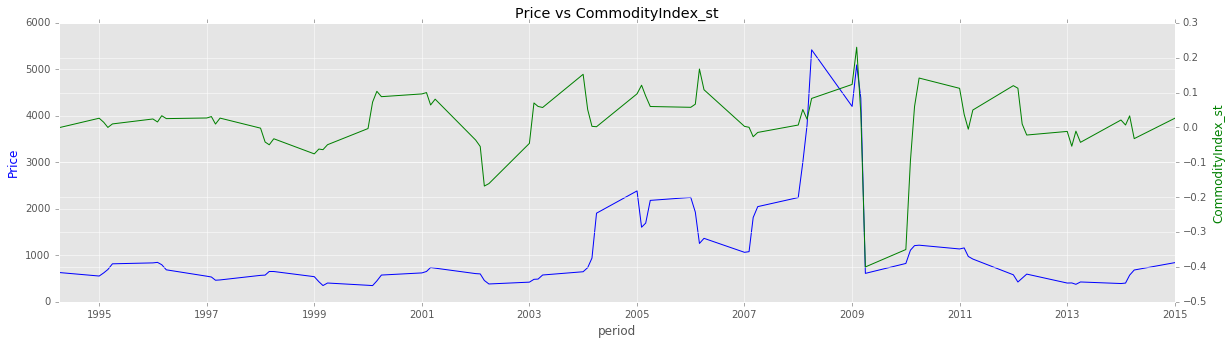

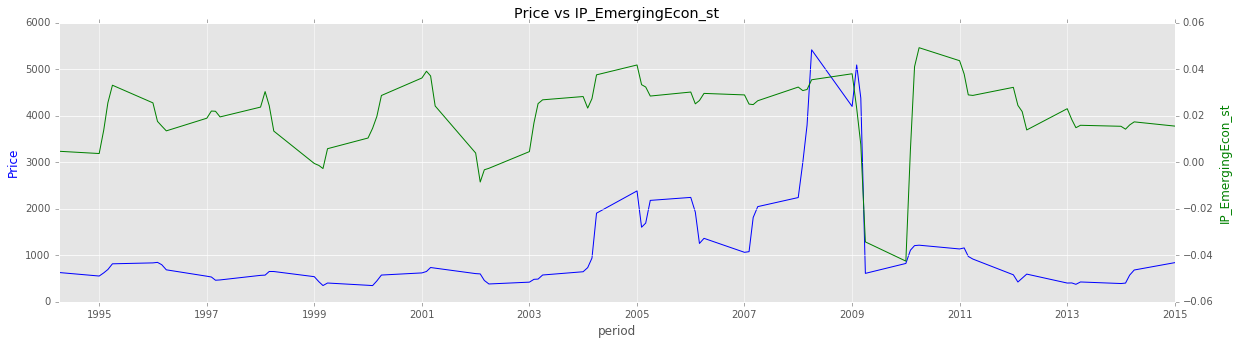

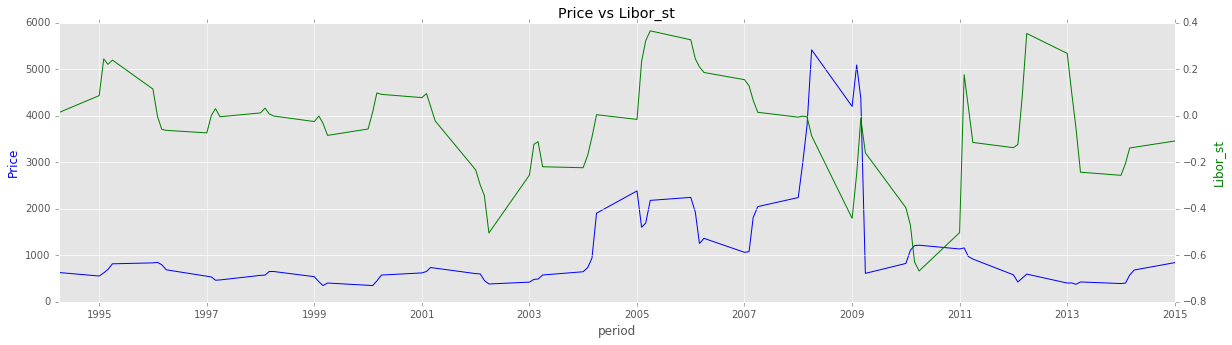

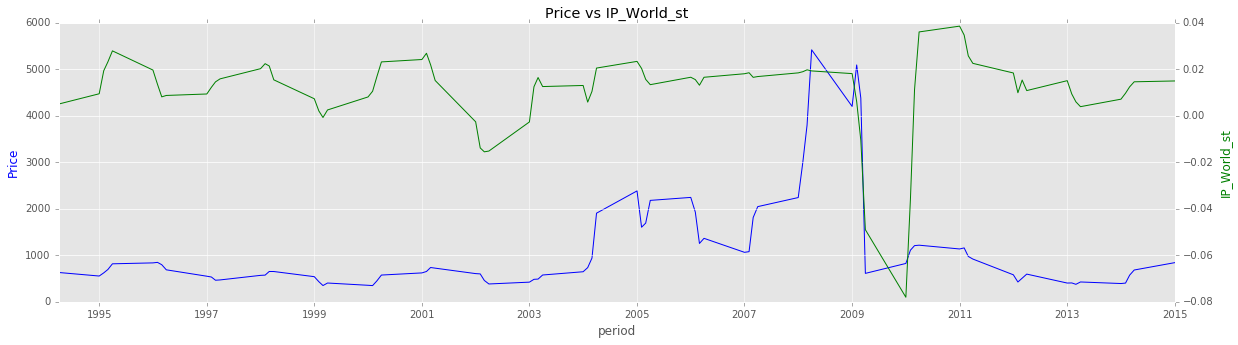

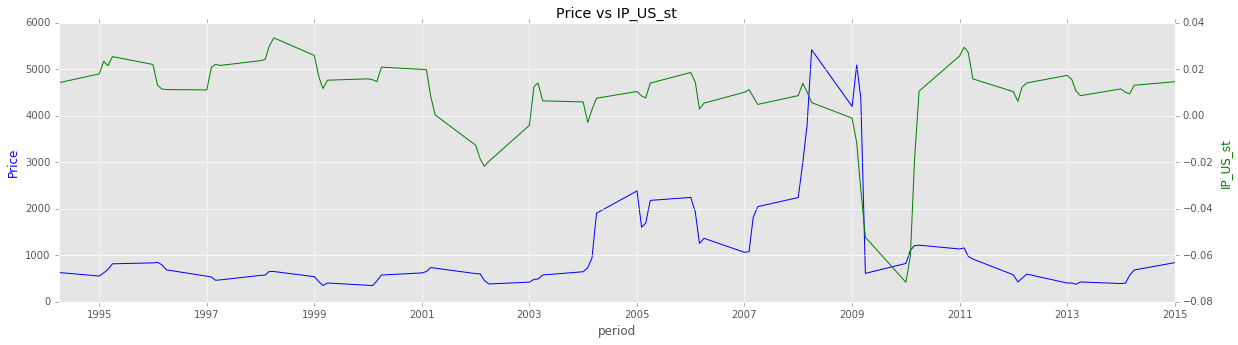

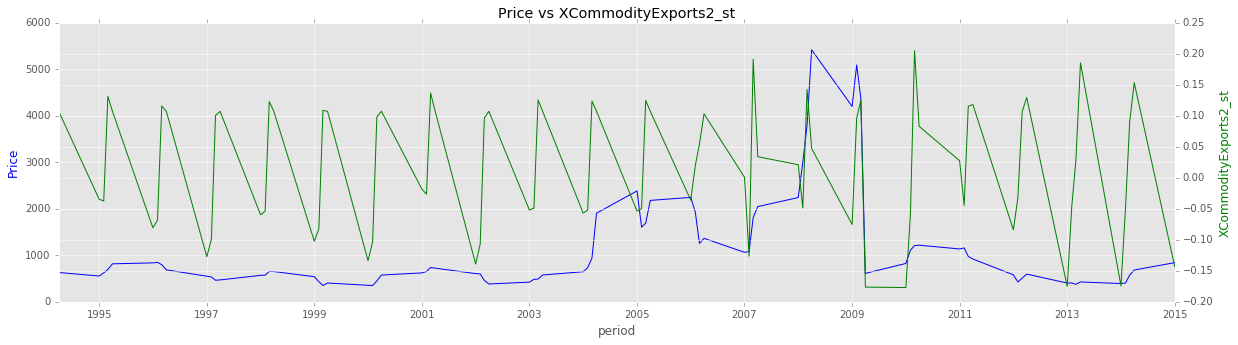

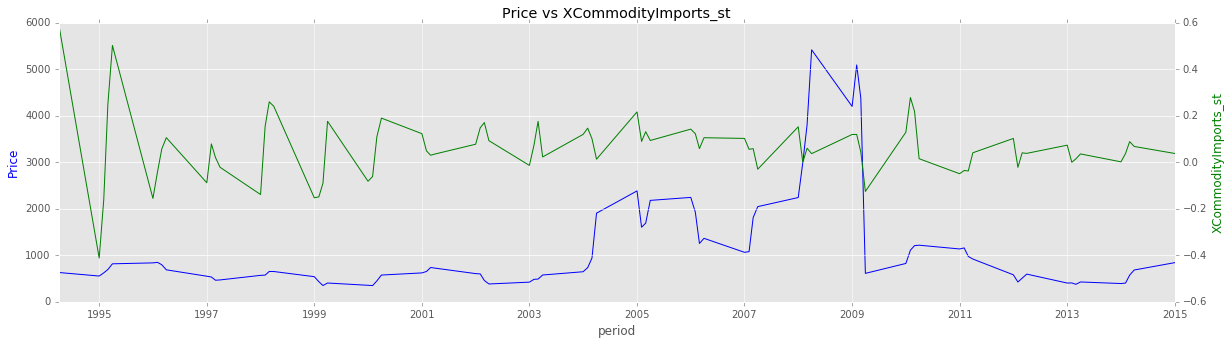

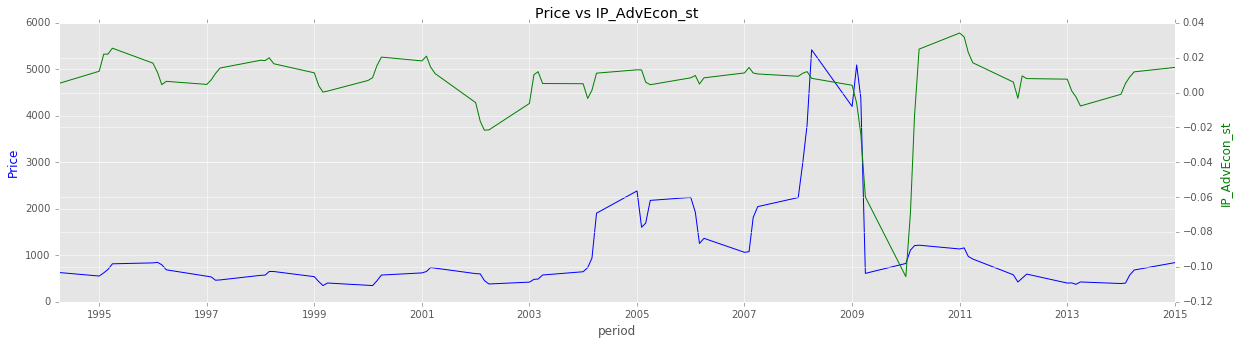

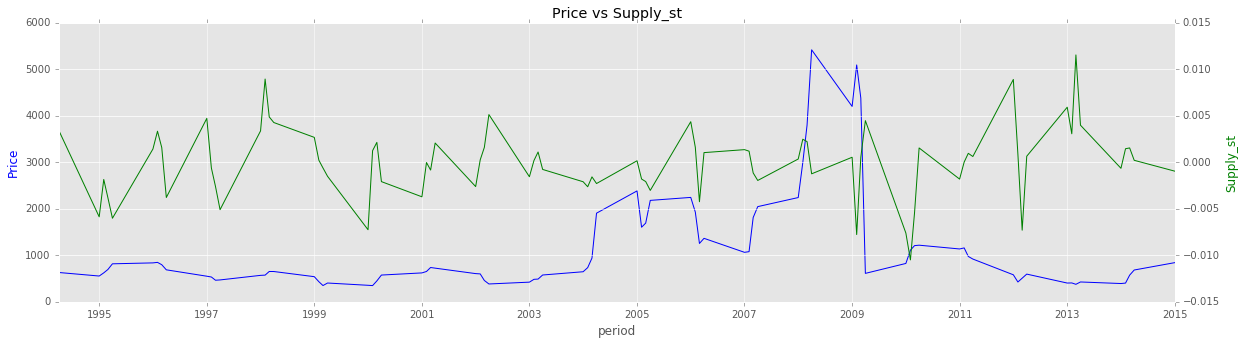

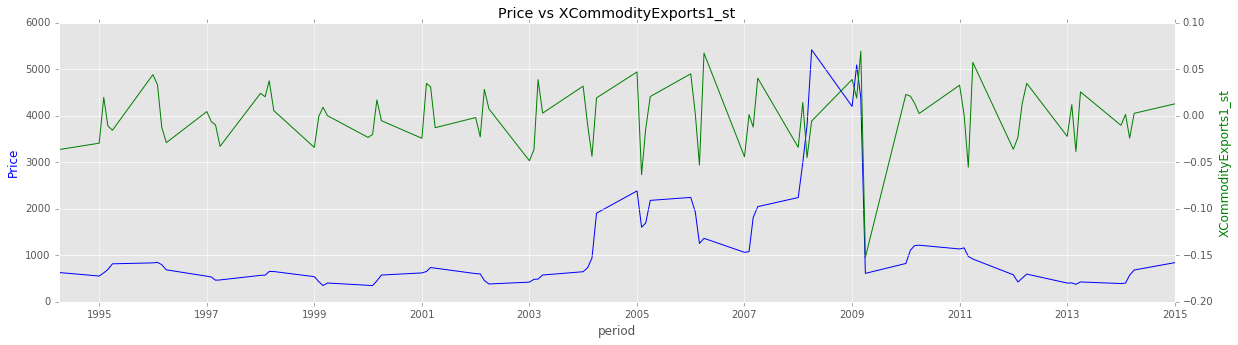

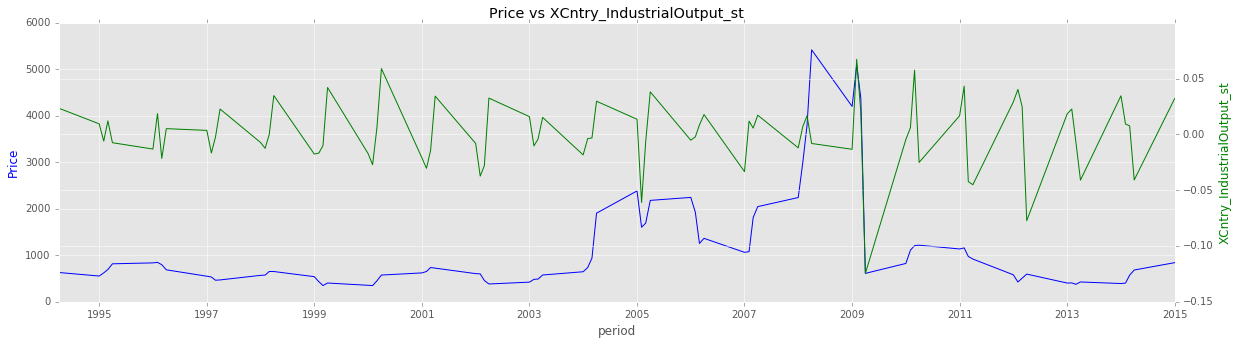

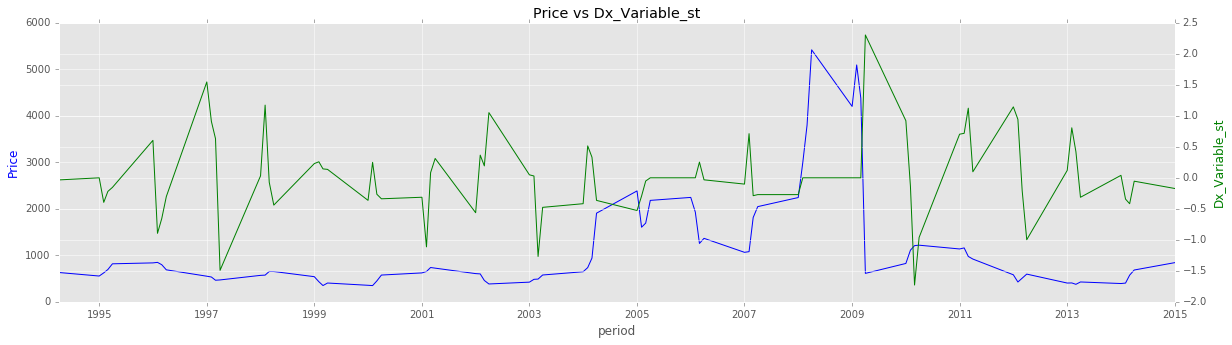

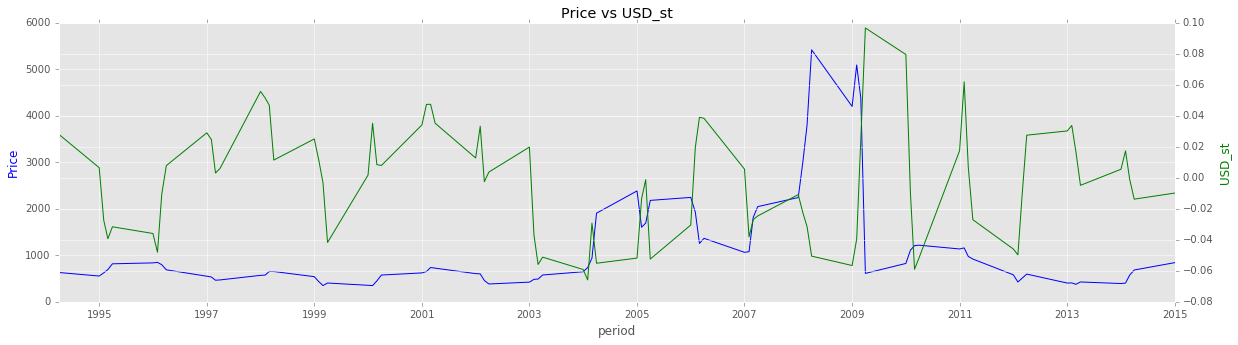

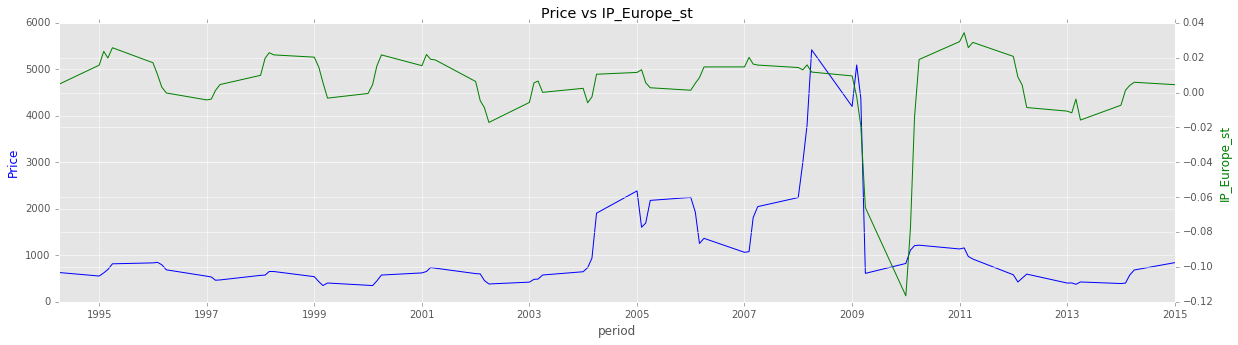

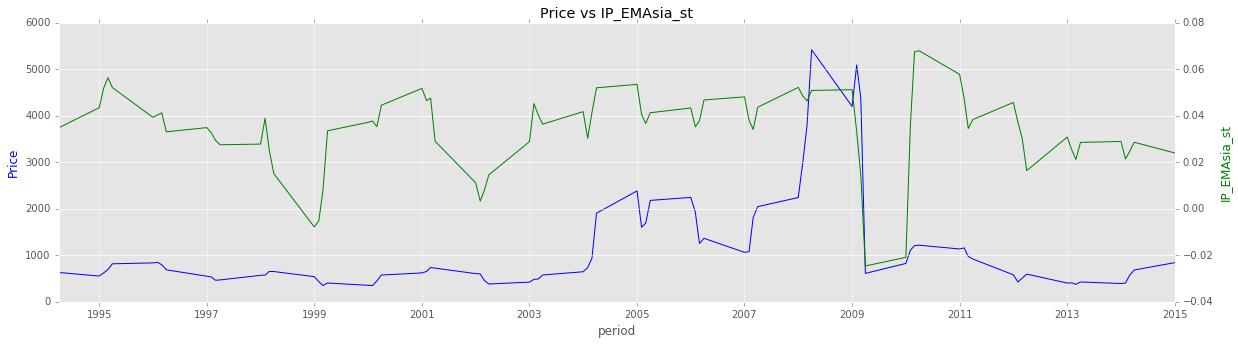

In [14]:
updated_predictor_list = [i for i in predictors if i + '_st' not in stationarized_var.keys()]\
                            +  stationarized_var.keys()


for v in updated_predictor_list:
    
    fig, ax1 = plt.subplots(figsize=(20,5))
    ax2 = ax1.twinx() 
    ax1.plot(data.period, data[target_name], 'b-') 
    ax2.plot(data.period, data[v], 'g-') 
    
    ax1.set_xlabel('period') 
    ax1.set_ylabel(target_name, color='b') 
    ax2.set_ylabel(v, color='g')
    
    plt.title(target_name + ' vs ' + v)
    plt.show()

## finding relationship between price and predictors

* correlation

note: impute diagnoal as zero to reflect color-scale


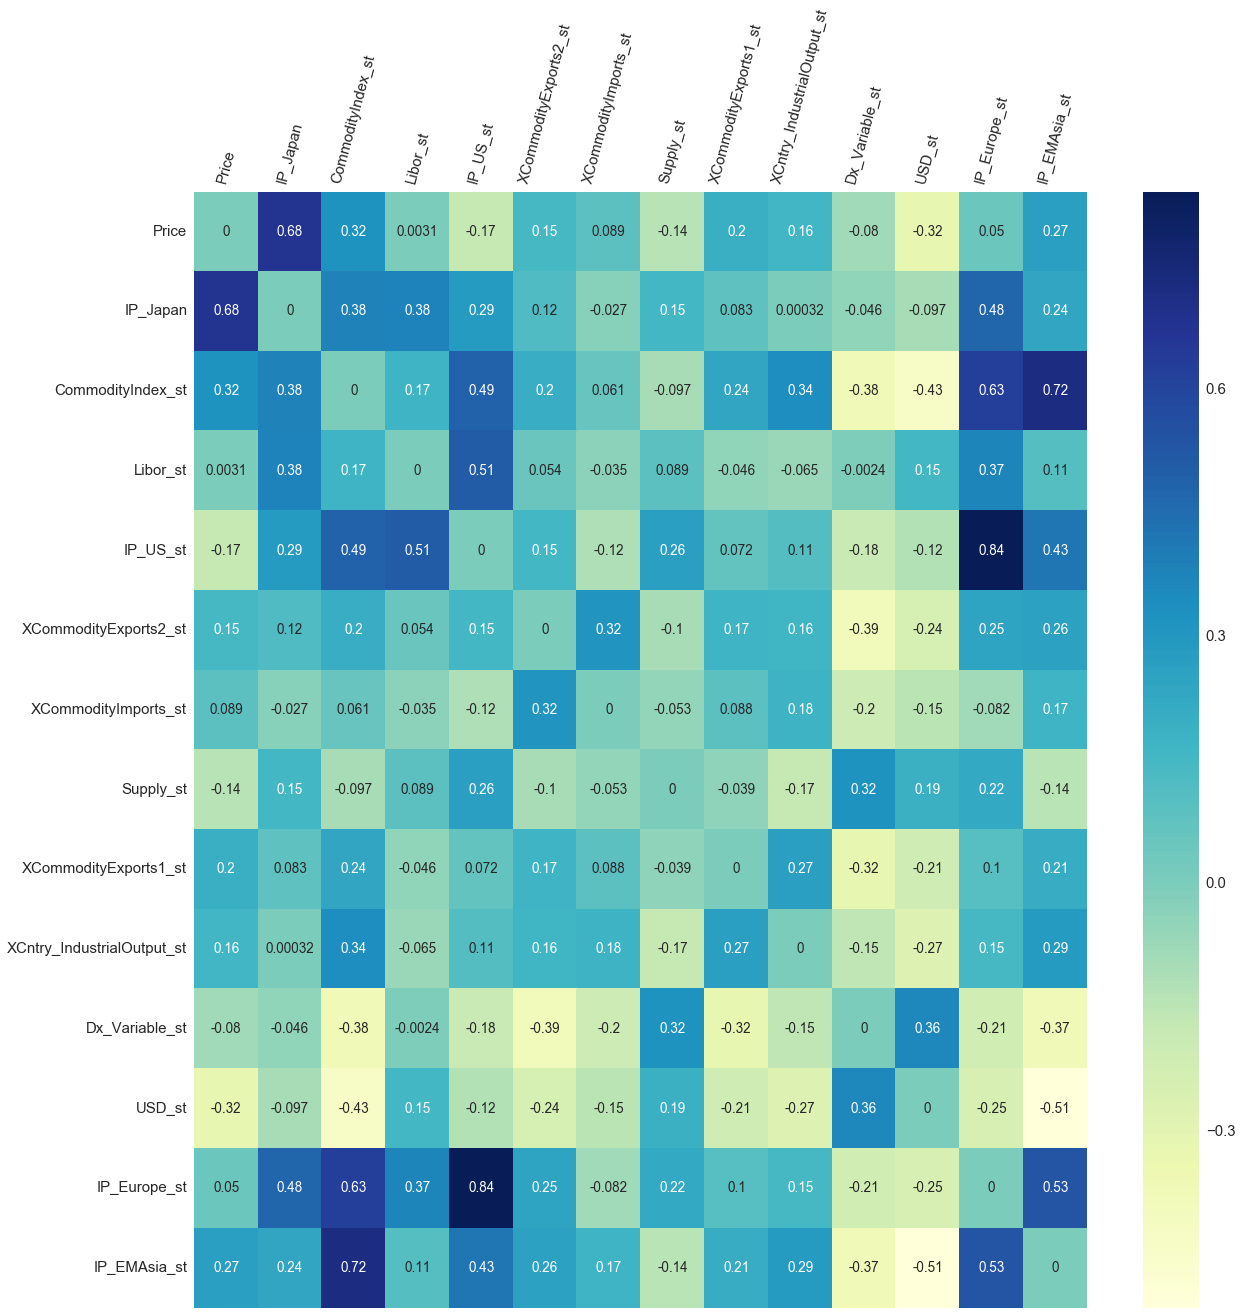

In [34]:
corr_matrix = data[[target_name] + updated_predictor_list].corr(method = 'pearson')

corr_matrix = corr_matrix.replace(1, 0)

%matplotlib inline

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,20)) 

sns.heatmap(corr_matrix, annot=True,ax = ax,annot_kws={"size": 13.5}, cmap="YlGnBu")

ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(corr_matrix.columns, rotation=75)

print 'note: impute diagnoal as zero to reflect color-scale'

In [18]:
#top correlated pairs
corr_array = corr_matrix.unstack().reset_index()
corr_array.columns = ['feature_1','feature_2','correlation_coefficient']

corr_array = corr_array.loc[corr_array['correlation_coefficient'] <> 1]
corr_array = corr_array.drop_duplicates(subset='correlation_coefficient')

corr_array = corr_array.sort_values(by = 'correlation_coefficient',ascending = False)

top_corr_predictor_pairs = corr_array.loc[corr_array['feature_1'] <> target_name].head(10)

print 'top correlated pairs among predictors'
top_corr_predictor_pairs

top correlated pairs among predictors


feature_1           feature_2  correlation_coefficient
94          IP_World_st       IP_AdvEcon_st                 0.963494
168       IP_AdvEcon_st        IP_Europe_st                 0.950191
111            IP_US_st       IP_AdvEcon_st                 0.927456
100         IP_World_st        IP_Europe_st                 0.910163
56   IP_EmergingEcon_st         IP_World_st                 0.877094
67   IP_EmergingEcon_st        IP_EMAsia_st                 0.866139
91          IP_World_st            IP_US_st                 0.856418
117            IP_US_st        IP_Europe_st                 0.840521
37    CommodityIndex_st  IP_EmergingEcon_st                 0.792912
39    CommodityIndex_st         IP_World_st                 0.743105

In [19]:
corr_array['abs_corr'] = abs(corr_array['correlation_coefficient'])
corr_array = corr_array.sort_values(by = 'abs_corr',ascending = False)

top_corr_predictor = corr_array.loc[corr_array['feature_1'] == target_name].head(10)

print 'top correlated variable with Dependent variable'
top_corr_predictor[['feature_1','feature_2','correlation_coefficient']]

top correlated variable with Dependent variable


feature_1                   feature_2  correlation_coefficient
1      Price                    IP_Japan                 0.680710
2      Price           CommodityIndex_st                 0.322106
14     Price                      USD_st                -0.316633
3      Price          IP_EmergingEcon_st                 0.311582
16     Price                IP_EMAsia_st                 0.266674
11     Price       XCommodityExports1_st                 0.198078
6      Price                    IP_US_st                -0.173084
12     Price  XCntry_IndustrialOutput_st                 0.162166
7      Price       XCommodityExports2_st                 0.147515
10     Price                   Supply_st                -0.135079

* modeling
  * step 1: Check for VIF and remove predictor with high VIF

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

vif = [variance_inflation_factor(data[updated_predictor_list].values, i) \
       for i in range(data[updated_predictor_list].shape[1])]

vif_pd = pd.DataFrame({'feature':updated_predictor_list,'VIF':vif})
vif_pd = vif_pd[['feature','VIF']]

vif_pd = vif_pd.sort_values(by = 'VIF', ascending = False)
print 'Variance inflation Factor'
vif_pd

Variance inflation Factor


feature         VIF
4                  IP_World_st  570.846851
8                IP_AdvEcon_st  201.425993
2           IP_EmergingEcon_st  189.666442
15                IP_EMAsia_st   24.288709
5                     IP_US_st   16.430016
14                IP_Europe_st   15.654819
0                     IP_Japan   13.666833
1            CommodityIndex_st    3.571495
12              Dx_Variable_st    1.823604
7         XCommodityImports_st    1.697356
13                      USD_st    1.637925
3                     Libor_st    1.637378
9                    Supply_st    1.528944
6        XCommodityExports2_st    1.462452
11  XCntry_IndustrialOutput_st    1.392209
10       XCommodityExports1_st    1.286811

In [21]:
print 'remove top 3 high VIF feature:'
f_high_vif = vif_pd.head(3).feature
f_high_vif

remove top 3 high VIF feature:


4           IP_World_st
8         IP_AdvEcon_st
2    IP_EmergingEcon_st
Name: feature, dtype: object

   * step 2: normalize X to reduce multicollinearity and run initial model

In [22]:
updated_predictor_list = [i for i in updated_predictor_list if i not in f_high_vif.tolist()]

X = data[updated_predictor_list]
Y = data[[target_name]]

X = sm.add_constant(X)


# solve multi-colinearity issue
norm_x = X.values
for i, name in enumerate(X):
    if name == "const":
        continue
    norm_x[:,i] = X[name]/np.linalg.norm(X[name])

In [23]:
norm_x_df = pd.DataFrame(data = norm_x, columns = X.columns, index = X.index)

fit = sm.OLS(Y, norm_x_df).fit()
print fit.summary2()

                             Results: Ordinary least squares
Model:                     OLS                     Adj. R-squared:            0.718     
Dependent Variable:        Price                   AIC:                       1284.1114 
Date:                      2017-10-09 01:32        BIC:                       1317.8054 
No. Observations:          82                      Log-Likelihood:            -628.06   
Df Model:                  13                      F-statistic:               16.90     
Df Residuals:              68                      Prob (F-statistic):        1.82e-16  
R-squared:                 0.764                   Scale:                     3.1735e+05
----------------------------------------------------------------------------------------
                              Coef.     Std.Err.     t    P>|t|     [0.025      0.975]  
----------------------------------------------------------------------------------------
const                      -12680.4661  1317.1532

* step 3: check DFBETAS to see if any influential obs need to be removed
  * a standardized measure of how much each coefficient changes when that observation is left out.
  * consider DBETAS in absolute value greater than  2/sqrt(N)  to be influential observations

In [24]:
infl = fit.get_influence()
DBETAS = infl.summary_frame().filter(regex="dfb")

In [25]:
criteria_value = 2./len(X)**.5
print '2/sqrt(N) :',criteria_value

check_DBETAS = abs(DBETAS) > criteria_value
check_DBETAS['sum'] = check_DBETAS.sum(axis=1)

2/sqrt(N) : 0.22086305215


In [26]:
indx_infl_obs = check_DBETAS.loc[check_DBETAS['sum'] > 0].index
print 'Number of influential obs to be removed: ', len(indx_infl_obs)

Number of influential obs to be removed:  30


 * step 4: re-fit model after removing influential obs

In [27]:
norm_x_df_updated = norm_x_df.iloc[norm_x_df.index.isin(indx_infl_obs) == False,:]
Y_updated = Y.iloc[Y.index.isin(indx_infl_obs) == False,:]


fit_updated = sm.OLS(Y_updated, norm_x_df_updated).fit()
print fit_updated.summary2()

                             Results: Ordinary least squares
Model:                       OLS                     Adj. R-squared:            0.817   
Dependent Variable:          Price                   AIC:                       744.2229
Date:                        2017-10-09 01:32        BIC:                       771.5403
No. Observations:            52                      Log-Likelihood:            -358.11 
Df Model:                    13                      F-statistic:               18.47   
Df Residuals:                38                      Prob (F-statistic):        1.55e-12
R-squared:                   0.863                   Scale:                     76826.  
----------------------------------------------------------------------------------------
                              Coef.     Std.Err.     t    P>|t|     [0.025      0.975]  
----------------------------------------------------------------------------------------
const                      -11135.2307  1179.5497

* model results summary

In [28]:
rsquare_summary = pd.DataFrame({'Model': ['before removing influential obs','after removing influential obs'] ,\
 'Adjusted R-square':[fit.rsquared_adj, fit_updated.rsquared_adj]})
rsquare_summary = rsquare_summary[['Model','Adjusted R-square']]

pd.set_option('colheader_justify', 'left')
rsquare_summary

Model                             Adjusted R-square
0  before removing influential obs  0.718446         
1   after removing influential obs  0.816583

In [29]:
coeff_df = pd.DataFrame({'coefficient':fit_updated.params,
                         'p-value':fit_updated.pvalues}).reset_index()
coeff_df.columns = ['feature','coefficient','p-value']
pd.set_option('precision',4)

pos_coeff_df_sig = coeff_df.loc[(coeff_df['p-value'] < 0.05) &\
                                (coeff_df['coefficient'] > 0) & \
                                (coeff_df['feature'] <> 'const'),:]

print 'Predictors that show POSTIVE impact on price with statistical significance: '
pos_coeff_df_sig

Predictors that show POSTIVE impact on price with statistical significance: 


feature                 coefficient  p-value   
1               IP_Japan  109284.0073  2.9407e-12
8  XCommodityExports1_st    1293.0005  1.0124e-02

In [30]:
neg_coeff_df_sig = coeff_df.loc[(coeff_df['p-value'] < 0.05) &\
                                (coeff_df['coefficient'] < 0) & \
                                (coeff_df['feature'] <> 'const'),:]

print 'Predictors that show NEGATIVE impact on price with statistical significance: '
neg_coeff_df_sig

Predictors that show NEGATIVE impact on price with statistical significance: 


feature        coefficient  p-value
4       IP_US_st -3234.8480    0.0036 
11        USD_st -2145.4079    0.0003 
12  IP_Europe_st -2206.4356    0.0348

In [31]:
pos_coeff_df_less_sig = coeff_df.loc[(coeff_df['p-value'] < 0.5) &\
                                 (coeff_df['p-value'] > 0.05)& \
                                 (coeff_df['coefficient'] > 0),:]

print 'Predictors that show POSITIVE impact on price with less statistical significance: '
pos_coeff_df_less_sig

Predictors that show POSITIVE impact on price with less statistical significance: 


feature                      coefficient  p-value
2            CommodityIndex_st  1393.4647    0.0993 
9   XCntry_IndustrialOutput_st   433.4551    0.3224 
13                IP_EMAsia_st  2377.9349    0.1355

In [32]:
neg_coeff_df_less_sig = coeff_df.loc[(coeff_df['p-value'] < 0.5) &\
                                 (coeff_df['p-value'] > 0.05)& \
                                 (coeff_df['coefficient'] < 0),:]

print 'Predictors that show Negative impact on price with less statistical significance: '
neg_coeff_df_less_sig

Predictors that show Negative impact on price with less statistical significance: 


feature     coefficient  p-value
7  Supply_st -517.8397     0.3302

In [33]:
coeff_df_non_sig = coeff_df.loc[(coeff_df['p-value'] >= 0.5) ,:]

print 'Predictors that do NOT show statistical significance: '
coeff_df_non_sig

Predictors that do NOT show statistical significance: 


feature                 coefficient  p-value
3                Libor_st  305.2199     0.6377 
5   XCommodityExports2_st  -19.2388     0.9672 
6    XCommodityImports_st  277.7575     0.6633 
10         Dx_Variable_st  316.1175     0.5264

## Conclusions

* Predictors that show **POSTIVE** impact on price with **strong** statistical significance (p-value < 0.05): 
  * `IP_Japan`, `XCommodityExports1_st`
* Predictors that show **NEGATIVE** impact on price with **strong** statistical significance (p-value < 0.05):  
  * `IP_US_st`,`USD_st`, `IP_Europe_st`
* Predictors that show **POSITIVE** impact on price with **less** statistical significance (p-value between 0.05 and 0.5): 
  * `CommodityIndex_st`,`XCntry_IndustrialOutput_st`, `IP_EMAsia_st`
* Predictors that show **NEGATIVE** impact on price with **less** statistical significance (p-value between 0.05 and 0.5):
  * `Supply_st`
* Predictors that do **NOT** show statistical significance (p-value > 0.5):
  * `Libor_st`,`XCommodityExports2_st`,`XCommodityImports_st`,`Dx_Variable_st`